#### Train a Convolutional Neural Network model for predicting cardiac arrhythmias

#### Import necessary libraries.

In [1]:

import time
import pandas as pd
import tensorflow as tf
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import seaborn as sns
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#### Load the dataset.

In [2]:

df = None

# Consider only lead2
column_names = ["idx", "ecg_id", "lead2", "arrhythmia_code"]
dtypes = {"idx" : "int32", "ecg_id" : "str", "lead2" : "float16", "arrhythmia_code" : "int16"}

try:
    print("\nStart loading CSV file...")
    df = pd.read_csv("../dataset/csv_files/ecg_sph_dataset.csv", sep="|", dtype = dtypes, usecols = column_names)
    print("\nFinish loading CSV file...")
except Exception as e:
    print("\nFail to load CSV file.")
    print("Error: {}".format(e))



Start loading CSV file...

Finish loading CSV file...


#### Display the dataset size.

In [3]:

df.shape


(128850000, 4)

#### Build a helper function to convert the records to the required format to perform a time series processing.

In [5]:

number_of_steps = 1250
number_of_features = 1

def get_new_columns_order(column_names_array):
    columns_series = pd.Series(column_names_array)
    column_idx_count = 0
    new_array = np.zeros(len(column_names_array), dtype = int)
    for column_idx in range(0, (number_of_steps * 4)):
        for column_idx_2 in range(0, number_of_features):
            new_array[column_idx + column_idx_2 * (number_of_steps * 4)] = column_idx_count
            column_idx_count += 1
    return new_array

def build_time_window_structure(df):
    # Splits the dataset into "time windows" to be used as a time series.
    # The function groups each 125 dataset records (CSV lines) into one record.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    All time windows (np.array)
    #    All target values (np.array)
    print("\nStarting build_time_window_structure function...")
    df["idx"] = df["idx"] % (number_of_steps * 4)
    df_aux = df.pivot_table(index = "ecg_id", columns = "idx", values = ["lead2"], aggfunc = "sum")
    new_columns = get_new_columns_order(df_aux.columns.values)
    df_aux.columns = list(new_columns)
    sorted_columns = sorted(df_aux.columns)
    df_modified = df_aux[sorted_columns]
    X_array = df_modified.values
    y_array = df["arrhythmia_code"].values
    y_array = y_array[::(number_of_steps * 4)]
    # Resample sample frequency to 125 hz.
    fs_original = 500 # Original frequency (Hz)
    fs_new = 125 # New frequency (Hz)
    downsampling_factor = int(fs_original / fs_new)
    nyquist_rate = fs_original / 2.0  # Nyquist rate
    cutoff_freq = fs_new / 2.0  # Cut off rate
    b, a = signal.butter(4, cutoff_freq / nyquist_rate, btype = "low")
    X_array_filtered = signal.filtfilt(b, a, X_array, axis = 1)
    X_array_125hz = X_array_filtered[:, ::downsampling_factor]
    print("\nShape of features: ", X_array_125hz.shape)
    print("Quantity os samples (labels): ", len(y_array))
    print("\nFinishing build_time_window_structure function.")
    return X_array_125hz, y_array


#### Build "time window" structure and show class distribution.

In [6]:

# Build "time window" structure to handle the dataset as a time series.
X_array, y_array = build_time_window_structure(df)
diagnostic_codes, count = np.unique(y_array, return_counts = True)
percentage_by_codes = [(i * 100 / np.sum(count)) for i in count]
category_count = list(zip(diagnostic_codes, count, percentage_by_codes))
category_count.sort(key = lambda x: x[1], reverse = True)

print("\nCheck dataset balance:")
for diagnostic_codes, count, percentage_by_codes in category_count:
    print(f"Diagnostic code = {diagnostic_codes:3.0f}   Qty = {count:8.0f}   Percentage = {percentage_by_codes:2.2f} %")



Starting build_time_window_structure function...

Shape of features:  (25770, 1250)
Quantity os samples (labels):  25770

Finishing build_time_window_structure function.

Check dataset balance:
Diagnostic code =   1   Qty =    13905   Percentage = 53.96 %
Diagnostic code =  22   Qty =     2659   Percentage = 10.32 %
Diagnostic code = 147   Qty =     1334   Percentage = 5.18 %
Diagnostic code =  23   Qty =     1123   Percentage = 4.36 %
Diagnostic code = 145   Qty =     1045   Percentage = 4.06 %
Diagnostic code = 105   Qty =      917   Percentage = 3.56 %
Diagnostic code =  60   Qty =      786   Percentage = 3.05 %
Diagnostic code =  21   Qty =      723   Percentage = 2.81 %
Diagnostic code =  50   Qty =      663   Percentage = 2.57 %
Diagnostic code = 146   Qty =      540   Percentage = 2.10 %
Diagnostic code = 106   Qty =      473   Percentage = 1.84 %
Diagnostic code =  30   Qty =      384   Percentage = 1.49 %
Diagnostic code = 125   Qty =      201   Percentage = 0.78 %
Diagnostic

#### Remove classes with less than 6 samples.

In [7]:

# Remove samples belonging to diagnostics 31, 37, 84, 87, 102, 143, 148, and 152 because these classes have less than 6 samples each (SMOTE restriction).
removed_idx = np.where(np.isin(y_array, [31, 37, 84, 87, 102, 143, 148, 152]))[0]
X_array = np.delete(X_array, removed_idx, axis = 0)
y_array = np.delete(y_array, removed_idx, axis = 0)

number_of_classes = 32

# Generate a class number for each diagnostic code and replace y_array values.
sorted_codes = sorted(set(y_array))
dict_aux = {}
for classes_idx in range(0, number_of_classes):
    dict_aux[classes_idx] = sorted_codes[classes_idx]
    y_array = [classes_idx if elem == sorted_codes[classes_idx] else elem for elem in y_array]
y_array = np.array(y_array)
print("\nShow classes identification:")
for key, value in dict_aux.items():
    print(f"Class: {key} - Arrhythmia code: {value}")

# Check for dataset balance.
diagnostic_classes, count = np.unique(y_array, return_counts = True)
percentage_by_class = [(i * 100 / np.sum(count)) for i in count]
category_count = list(zip(diagnostic_classes, count, percentage_by_class))
category_count.sort(key = lambda x: x[1], reverse = True)
print("\nCheck for dataset balance:")
for diagnostic_classes, count, percentage_by_class in category_count:
    print(f"Class = {diagnostic_classes:3.0f}   Qty = {count:8.0f}   Percentage = {percentage_by_class:2.2f} %")



Show classes identification:
Class: 0 - Arrhythmia code: 1
Class: 1 - Arrhythmia code: 21
Class: 2 - Arrhythmia code: 22
Class: 3 - Arrhythmia code: 23
Class: 4 - Arrhythmia code: 30
Class: 5 - Arrhythmia code: 36
Class: 6 - Arrhythmia code: 50
Class: 7 - Arrhythmia code: 51
Class: 8 - Arrhythmia code: 54
Class: 9 - Arrhythmia code: 60
Class: 10 - Arrhythmia code: 80
Class: 11 - Arrhythmia code: 82
Class: 12 - Arrhythmia code: 83
Class: 13 - Arrhythmia code: 88
Class: 14 - Arrhythmia code: 101
Class: 15 - Arrhythmia code: 104
Class: 16 - Arrhythmia code: 105
Class: 17 - Arrhythmia code: 106
Class: 18 - Arrhythmia code: 108
Class: 19 - Arrhythmia code: 120
Class: 20 - Arrhythmia code: 121
Class: 21 - Arrhythmia code: 125
Class: 22 - Arrhythmia code: 140
Class: 23 - Arrhythmia code: 142
Class: 24 - Arrhythmia code: 145
Class: 25 - Arrhythmia code: 146
Class: 26 - Arrhythmia code: 147
Class: 27 - Arrhythmia code: 155
Class: 28 - Arrhythmia code: 160
Class: 29 - Arrhythmia code: 161
Class

#### Define a function for training a CNN model.

In [7]:

def train_cnn_model(cnn_model, X_train, y_train, X_test, y_test, num_epochs, batch_size, validation_split, model_cfg_file):
    # Train a CNN model.
    # Parameters:
    #    cnn_model (Sequential): model to be trained.
    #    X_train (np.array): array of features values.
    #    X_test (np.array): array of features values.
    #    y_train (np.array): array of target values.
    #    y_test (np.array): array of target values.
    #    nun_folds (int): number of folds.
    #    num_epochs (int): number of epochs of training.
    #    batch_size (int): batch size.
    #    validation_split (float): percentage of instances for validation set.
    #    model_cfg_file (str): file to save the configuration model.
    # Returns:
    #    history (History object): history of training metrics.

    # Train the CNN model and evaluate it.
    start_time = time.time()
    print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
    es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 30)
    with tf.device('/cpu:0'):
        history = cnn_model.fit(X_train, y_train, validation_split = validation_split, epochs = num_epochs, batch_size = batch_size, 
                                verbose = 1, callbacks = [es])
        cnn_model.save("../modelconfig/" + model_cfg_file)
        _, train_accuracy = cnn_model.evaluate(X_train, y_train, verbose = 0)
        _, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose = 0)
        elapsed_seconds = time.time() - start_time
        print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
        print("\nTrain Accuracy: {:.2f} %".format(train_accuracy * 100))
        print("Test Accuracy: {:.2f} %".format(test_accuracy * 100))
        print("\nEvaluate other metrics:")
        pred_classes = np.argmax(cnn_model.predict(X_test), axis = 1)
        truth_classes = y_test
        print(classification_report(truth_classes, pred_classes, zero_division = 0))
    return history


#### Define a function to build a baseline version of CNN model.

In [8]:

def create_baseline():
    act_fuction = "relu"
    k_init = "he_uniform"
    model = Sequential()
    model.add(Conv1D(filters = 8, kernel_size = 3, activation = act_fuction, kernel_initializer = k_init, 
                     input_shape = (number_of_steps, number_of_features)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(filters = 16, kernel_size = 5, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(Dense(number_of_classes, activation = 'softmax'))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model


#### Define a function to build a version 1 of CNN model.

In [9]:

def create_v1():
    act_fuction = "relu"
    k_init = "he_uniform"
    model = Sequential()
    model.add(Conv1D(filters = 8, kernel_size = 3, activation = act_fuction, kernel_initializer = k_init, 
                     input_shape = (number_of_steps, number_of_features)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters = 8, kernel_size = 3, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(filters = 16, kernel_size = 5, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(Conv1D(filters = 16, kernel_size = 5, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(512, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(Dense(number_of_classes, activation = 'softmax'))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model


#### Use SMOTE technique to generate upsampling.

In [8]:

print("\nGenerating upsampling through SMOTE...")

smote = SMOTE(sampling_strategy = "auto", k_neighbors = 5, random_state = 42)
X_array_res, y_array_res = smote.fit_resample(X_array, y_array)

dict_samples_per_class = {}
nr_samples_per_class = 6250
for category_ids, count, percentage_of_categories in category_count:
    dict_samples_per_class[category_ids] = nr_samples_per_class
rus = RandomUnderSampler(sampling_strategy = dict_samples_per_class, random_state = 42)
X_array_res, y_array_res = rus.fit_resample(X_array_res, y_array_res)

print("\n{} samples after upsampling.".format(len(y_array_res)))
print("\nFinishing upsampling.")



Generating upsampling through SMOTE...

200000 samples after upsampling.

Finishing upsampling.


#### Split the dataset for training.

In [9]:

# Scale features using statistics that are robust to outliers.
print("Starting dataset split...")
rb_scaler = RobustScaler()
rb_scaler.fit(X_array_res)
X_array_samples = rb_scaler.transform(X_array_res)
# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_array_samples = X_array_samples.reshape((X_array_samples.shape[0], number_of_steps, number_of_features))
# Split train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_array_samples, y_array_res, test_size = 0.2, stratify = y_array_res, random_state = 42)
print("Finishing dataset split.")


Starting dataset split...
Finishing dataset split.


#### Train the baseline version of CNN model.

In [13]:

bs_model = create_baseline()
bs_num_epochs = 300
bs_batch_size = 32
bs_validation_split = 0.1

training_history = train_cnn_model(bs_model, X_train, y_train, X_test, y_test, bs_num_epochs, bs_batch_size, bs_validation_split, "baseline_model.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1248, 8)           32        
                                                                 
 batch_normalization (BatchN  (None, 1248, 8)          32        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 624, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 620, 16)           656       
                                                                 
 batch_normalization_1 (Batc  (None, 620, 16)          64        
 hNormalization)                                                 
                                                        

#### Train the version 1 of CNN model.

In [14]:

v1_model = create_v1()
v1_num_epochs = 300
v1_batch_size = 32
v1_validation_split = 0.1

training_history_v1 = train_cnn_model(v1_model, X_train, y_train, X_test, y_test, v1_num_epochs, v1_batch_size, v1_validation_split, "v1_model.h5")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1248, 8)           32        
                                                                 
 batch_normalization_3 (Batc  (None, 1248, 8)          32        
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 1246, 8)           200       
                                                                 
 batch_normalization_4 (Batc  (None, 1246, 8)          32        
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 623, 8)           0         
 1D)                                                             
                                                      

#### Plot the history of accuracy of training.

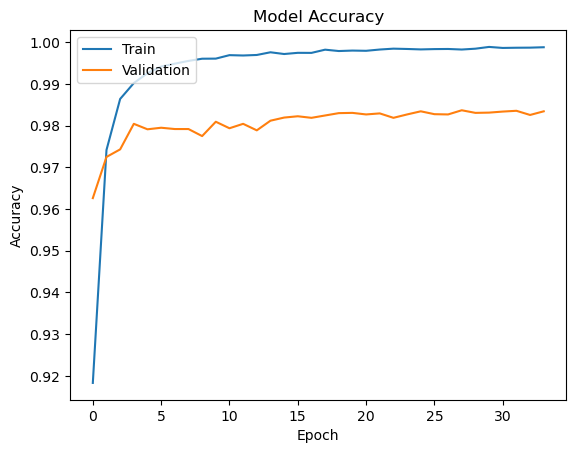

In [15]:

plt.plot(training_history_v1.history["accuracy"])
plt.plot(training_history_v1.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()


#### Plot the history of loss of training.

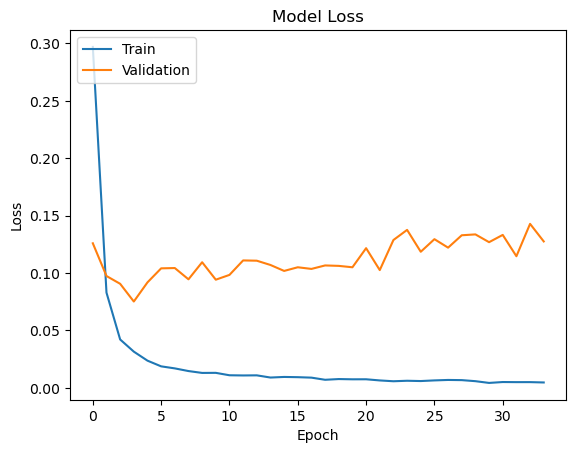

In [16]:

plt.plot(training_history_v1.history["loss"])
plt.plot(training_history_v1.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()


#### Apply LIME technique to explain model predictions.

c:\DeveloperTools\python\3.11.0\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\DeveloperTools\python\3.11.0\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(



Explain prediction for class 0:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 0 prediction:

Feature 436 - Contribution value: 0.02635436140140213
Feature 1001 - Contribution value: 0.025522109866886702
Feature 87 - Contribution value: 0.024398175982895016
Feature 426 - Contribution value: 0.022344741144898407
Feature 511 - Contribution value: 0.02062441222754663
Feature 545 - Contribution value: 0.020455042104903388
Feature 68 - Contribution value: 0.020056660317728476
Feature 848 - Contribution value: 0.019780929629674746
Feature 297 - Contribution value: 0.019647871675930774
Feature 111 - Contribution value: 0.018715584270253747
Feature 1246 - Contribution value: 0.01858115770472687
Feature 169 - Contribution value: 0.018396694951853806
Feature 968 - Contribution value: 0.01780069783678756
Feature 414 - Contribution value: 0.017726622766395212
Feature 85 - Contribution value: 0.017554736736631122
Feature 1000 - Contribution value: 0.01750771024452

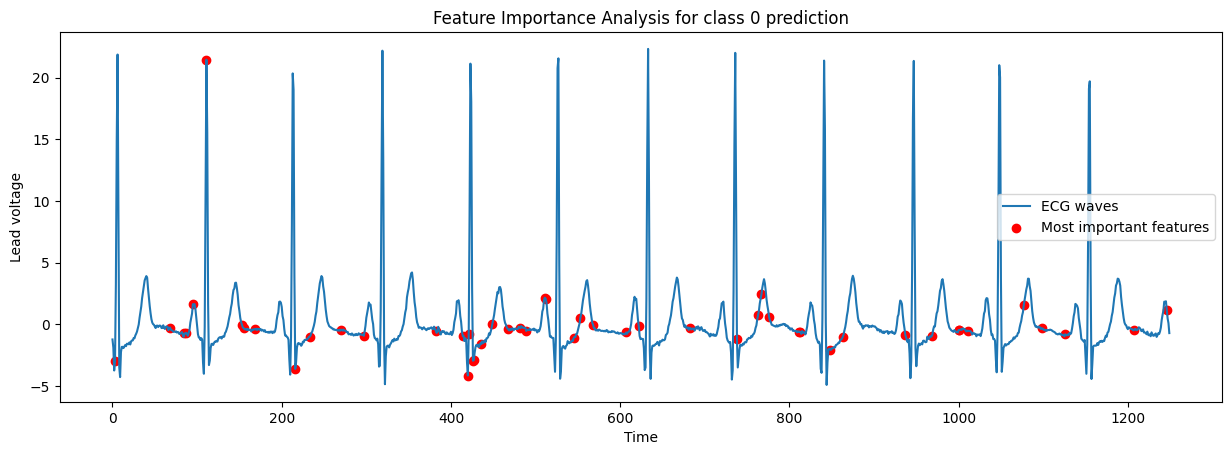


Explain prediction for class 1:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 1 prediction:

Feature 609 - Contribution value: 0.025740488197537742
Feature 256 - Contribution value: 0.025482138066819874
Feature 58 - Contribution value: 0.024414731177557922
Feature 456 - Contribution value: 0.021077773552464894
Feature 491 - Contribution value: 0.02077248742973748
Feature 749 - Contribution value: 0.02042532460071567
Feature 1152 - Contribution value: 0.020092647213048685
Feature 703 - Contribution value: 0.020092437944743288
Feature 482 - Contribution value: 0.0199973064046889
Feature 1248 - Contribution value: 0.019850019527444206
Feature 106 - Contribution value: 0.01939252608851325
Feature 240 - Contribution value: 0.019237421476829122
Feature 23 - Contribution value: 0.019069213950812108
Feature 776 - Contribution value: 0.018985882318405086
Feature 997 - Contribution value: 0.018932534168305315
Feature 864 - Contribution value: 0.018828139311069

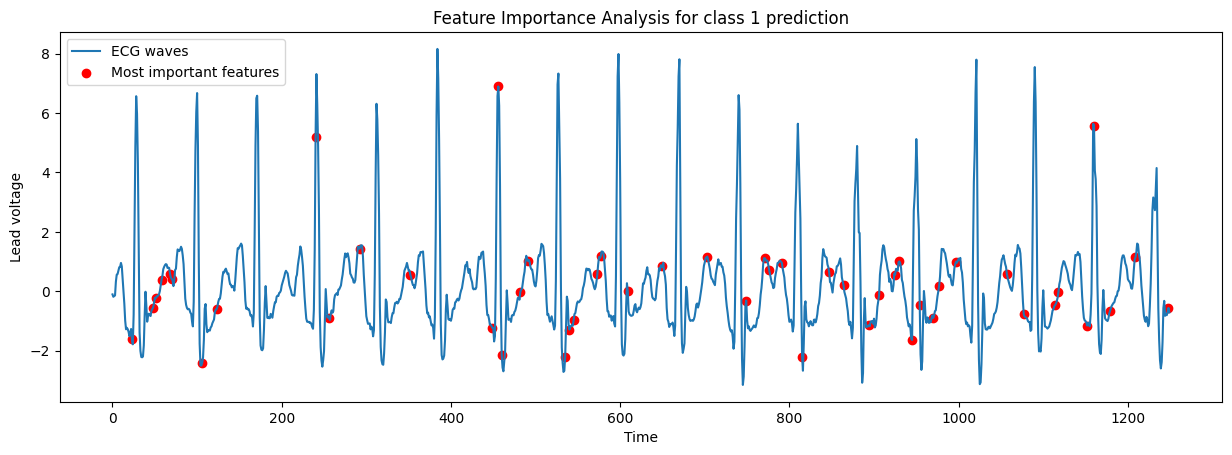


Explain prediction for class 2:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 2 prediction:

Feature 1126 - Contribution value: 0.028803751816247943
Feature 649 - Contribution value: 0.025740564266397505
Feature 748 - Contribution value: 0.025066029887179656
Feature 479 - Contribution value: 0.025021916391469366
Feature 1093 - Contribution value: 0.024463207526209764
Feature 481 - Contribution value: 0.023311725113039406
Feature 1095 - Contribution value: 0.02307714310648183
Feature 350 - Contribution value: 0.023013448584079717
Feature 894 - Contribution value: 0.022549903352682615
Feature 656 - Contribution value: 0.022537560190801973
Feature 619 - Contribution value: 0.022272362463078885
Feature 100 - Contribution value: 0.021822195912097213
Feature 136 - Contribution value: 0.021466458711770844
Feature 778 - Contribution value: 0.0209568000690336
Feature 1207 - Contribution value: 0.02029612620915609
Feature 535 - Contribution value: 0.0199270646

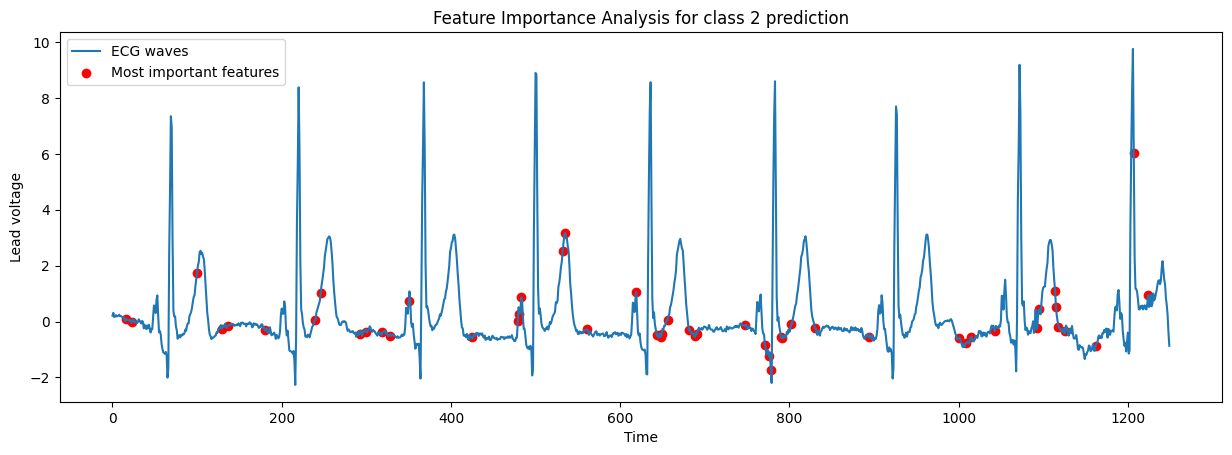


Explain prediction for class 3:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 3 prediction:

Feature 848 - Contribution value: 0.02439292845800033
Feature 1132 - Contribution value: 0.024351032553921955
Feature 800 - Contribution value: 0.023372876181609045
Feature 1113 - Contribution value: 0.023360972052759863
Feature 1043 - Contribution value: 0.02207998380740048
Feature 869 - Contribution value: 0.021605513043151035
Feature 776 - Contribution value: 0.02145775721140873
Feature 136 - Contribution value: 0.021343507005263797
Feature 68 - Contribution value: 0.020873301791100994
Feature 329 - Contribution value: 0.020503982716895106
Feature 512 - Contribution value: 0.020348017530865226
Feature 543 - Contribution value: 0.02027391913987197
Feature 107 - Contribution value: 0.02000224217797805
Feature 87 - Contribution value: 0.019577265116968206
Feature 750 - Contribution value: 0.01954609744160897
Feature 784 - Contribution value: 0.019369918284446

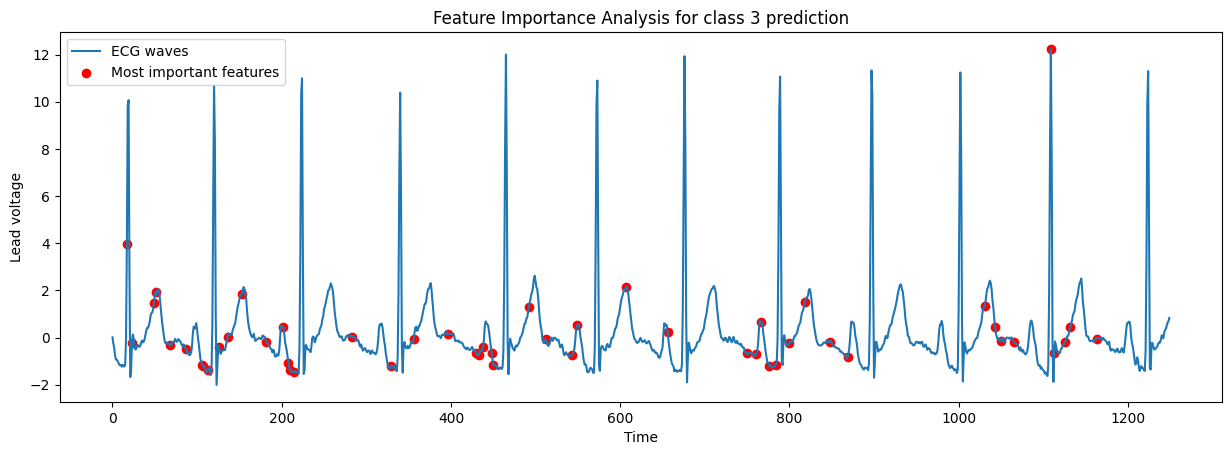


Explain prediction for class 4:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 4 prediction:

Feature 778 - Contribution value: 0.02599878501410846
Feature 1003 - Contribution value: 0.024424109361464934
Feature 776 - Contribution value: 0.02326718299095233
Feature 700 - Contribution value: 0.022881536833255767
Feature 709 - Contribution value: 0.022814777078865697
Feature 350 - Contribution value: 0.02200782529399214
Feature 311 - Contribution value: 0.021936082938651055
Feature 1014 - Contribution value: 0.021868911898480194
Feature 479 - Contribution value: 0.02105607154461144
Feature 330 - Contribution value: 0.020611037296972973
Feature 1152 - Contribution value: 0.020538229237777733
Feature 39 - Contribution value: 0.020100346439347924
Feature 187 - Contribution value: 0.01968653172498098
Feature 107 - Contribution value: 0.019439524407307892
Feature 28 - Contribution value: 0.019268255815875966
Feature 482 - Contribution value: 0.01920716639522

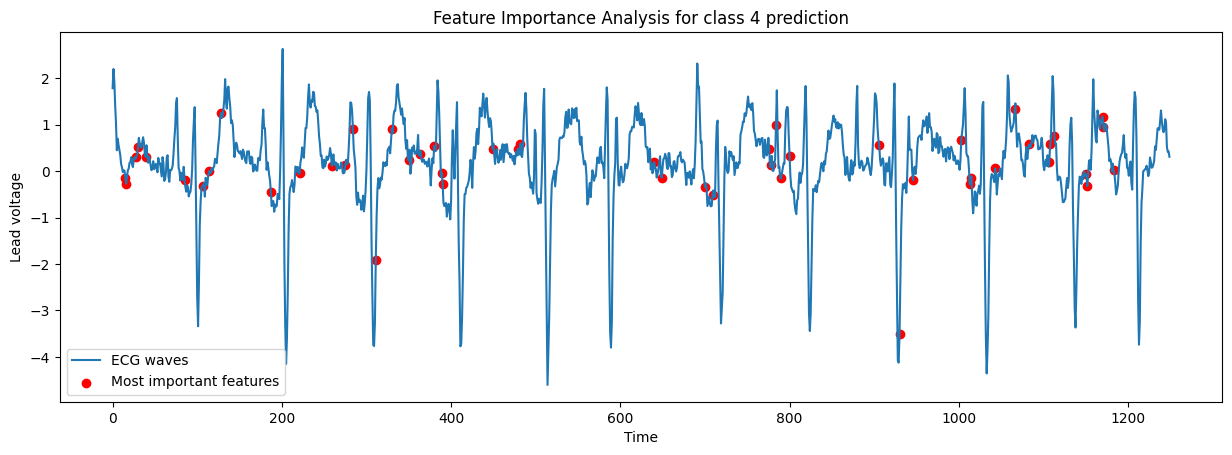


Explain prediction for class 5:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 5 prediction:

Feature 482 - Contribution value: 0.025049575798825822
Feature 968 - Contribution value: 0.024029683084865774
Feature 1115 - Contribution value: 0.022710111341937324
Feature 320 - Contribution value: 0.022144367282133114
Feature 700 - Contribution value: 0.021419985620040348
Feature 397 - Contribution value: 0.020136712028876756
Feature 490 - Contribution value: 0.019887001272620896
Feature 241 - Contribution value: 0.019561906101877087
Feature 17 - Contribution value: 0.019352092269062485
Feature 1046 - Contribution value: 0.01932755612950835
Feature 945 - Contribution value: 0.019143916743443505
Feature 556 - Contribution value: 0.019045834247801832
Feature 495 - Contribution value: 0.018962001690971494
Feature 1179 - Contribution value: 0.01882482590646557
Feature 436 - Contribution value: 0.018737727643602247
Feature 818 - Contribution value: 0.0184913037

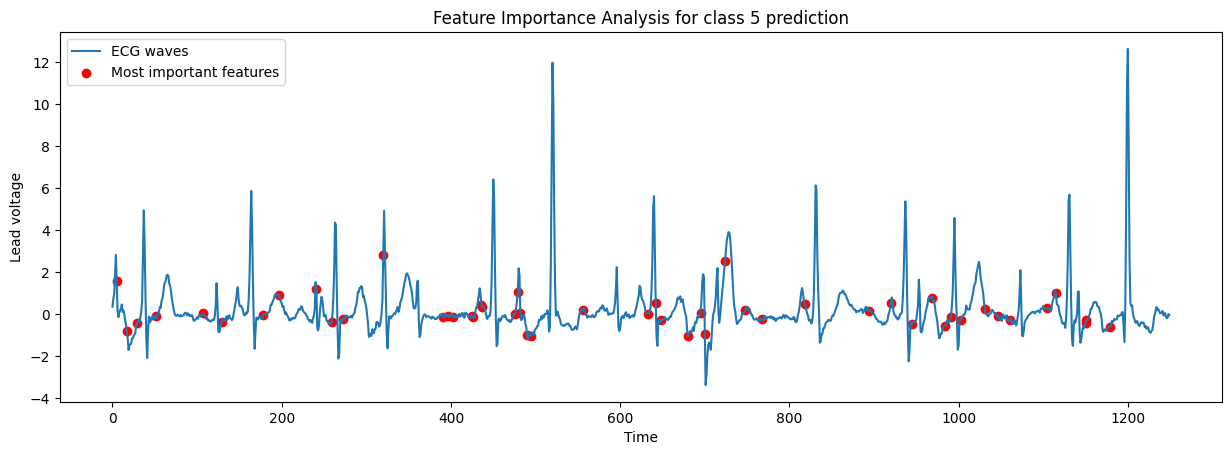


Explain prediction for class 6:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 6 prediction:

Feature 30 - Contribution value: 0.02811106225613186
Feature 506 - Contribution value: 0.026553689357456247
Feature 106 - Contribution value: 0.024066359822418972
Feature 359 - Contribution value: 0.02164155638044575
Feature 1119 - Contribution value: 0.021288235826091875
Feature 62 - Contribution value: 0.020823666374416443
Feature 693 - Contribution value: 0.02067524764140287
Feature 776 - Contribution value: 0.0202990439897297
Feature 1151 - Contribution value: 0.019968729520530987
Feature 750 - Contribution value: 0.01988312611535375
Feature 711 - Contribution value: 0.019768617477751712
Feature 507 - Contribution value: 0.01950322093831309
Feature 111 - Contribution value: 0.019442250256529982
Feature 162 - Contribution value: 0.019436026478872888
Feature 617 - Contribution value: 0.019243741607710266
Feature 29 - Contribution value: 0.018948663509294857

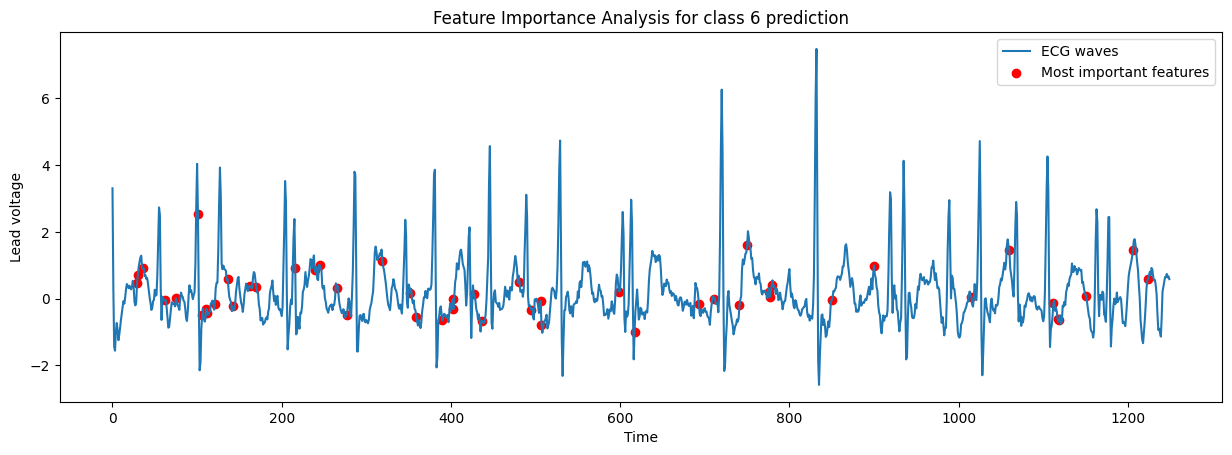


Explain prediction for class 7:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 7 prediction:

Feature 776 - Contribution value: 0.035869780450949136
Feature 29 - Contribution value: 0.023262785949913944
Feature 1010 - Contribution value: 0.022303087557281637
Feature 792 - Contribution value: 0.022058043824917967
Feature 292 - Contribution value: 0.02136305464717199
Feature 129 - Contribution value: 0.02085706425310716
Feature 1142 - Contribution value: 0.02038799765501215
Feature 650 - Contribution value: 0.019643204237516407
Feature 838 - Contribution value: 0.019609185869726264
Feature 1020 - Contribution value: 0.01937325125368022
Feature 968 - Contribution value: 0.019187940496228635
Feature 714 - Contribution value: 0.01885212080053886
Feature 239 - Contribution value: 0.018843205503424644
Feature 293 - Contribution value: 0.01879983387446139
Feature 870 - Contribution value: 0.018477031488729107
Feature 172 - Contribution value: 0.01842342040300

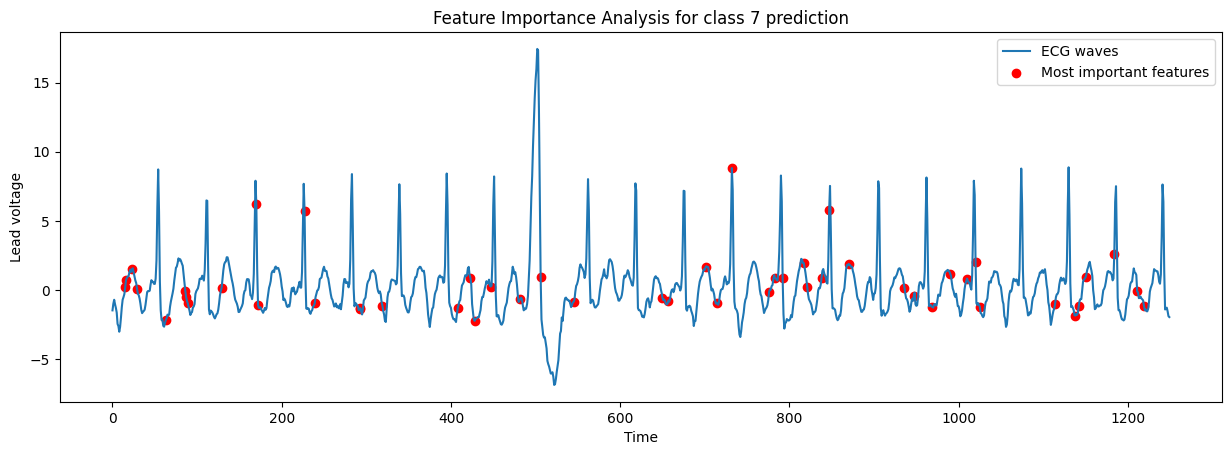


Explain prediction for class 8:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 8 prediction:

Feature 246 - Contribution value: 0.025831688892041797
Feature 49 - Contribution value: 0.02559638626195672
Feature 1010 - Contribution value: 0.025058995564857172
Feature 62 - Contribution value: 0.02312814248613712
Feature 778 - Contribution value: 0.02262085773274955
Feature 1163 - Contribution value: 0.020255926431907583
Feature 106 - Contribution value: 0.020081200752193034
Feature 1150 - Contribution value: 0.020072333061441766
Feature 732 - Contribution value: 0.01962164659760582
Feature 945 - Contribution value: 0.019136629223793035
Feature 330 - Contribution value: 0.018871728500378233
Feature 656 - Contribution value: 0.018647798323943914
Feature 981 - Contribution value: 0.018624605098265388
Feature 29 - Contribution value: 0.01860336796651712
Feature 1134 - Contribution value: 0.01838259513191022
Feature 1041 - Contribution value: 0.01827539245308

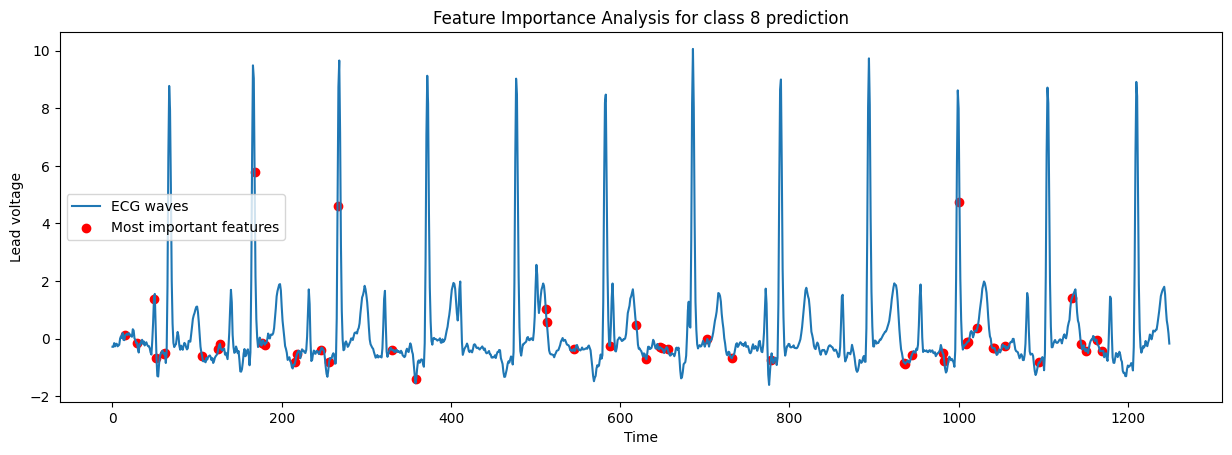


Explain prediction for class 9:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 9 prediction:

Feature 369 - Contribution value: 0.026356283532443847
Feature 778 - Contribution value: 0.02559571829319494
Feature 479 - Contribution value: 0.025225081345066368
Feature 112 - Contribution value: 0.02348578653704959
Feature 403 - Contribution value: 0.022358080331616615
Feature 124 - Contribution value: 0.022261008072788916
Feature 514 - Contribution value: 0.021733866582441086
Feature 363 - Contribution value: 0.021080701426898114
Feature 759 - Contribution value: 0.020730709184095093
Feature 494 - Contribution value: 0.02032007322422811
Feature 1113 - Contribution value: 0.01990362090637981
Feature 28 - Contribution value: 0.019441908527094612
Feature 49 - Contribution value: 0.018681920597324996
Feature 695 - Contribution value: 0.01838831824561642
Feature 416 - Contribution value: 0.018335562864073174
Feature 53 - Contribution value: 0.01809194603358699

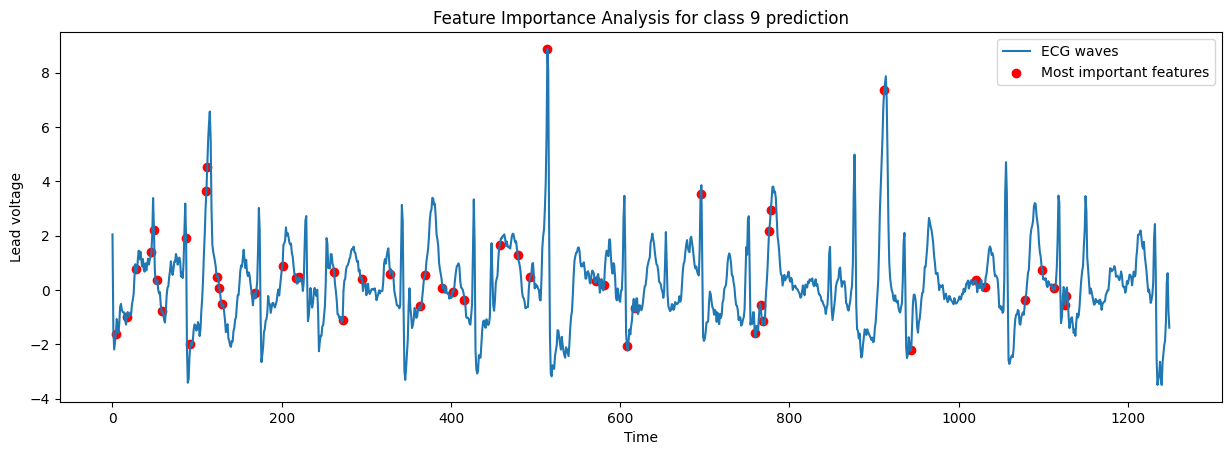


Explain prediction for class 10:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 10 prediction:

Feature 1113 - Contribution value: 0.025849794777616033
Feature 1134 - Contribution value: 0.021807267748932595
Feature 162 - Contribution value: 0.02177005680327498
Feature 295 - Contribution value: 0.021364714498827174
Feature 533 - Contribution value: 0.02135142318697734
Feature 59 - Contribution value: 0.02127029161276396
Feature 210 - Contribution value: 0.021202322665484826
Feature 750 - Contribution value: 0.021108422574724235
Feature 232 - Contribution value: 0.02011907856967955
Feature 778 - Contribution value: 0.019074488482009305
Feature 695 - Contribution value: 0.019056816124125707
Feature 495 - Contribution value: 0.01850473614348599
Feature 29 - Contribution value: 0.018338049419243205
Feature 522 - Contribution value: 0.01829051381144838
Feature 811 - Contribution value: 0.018192683413266398
Feature 107 - Contribution value: 0.01810179670223

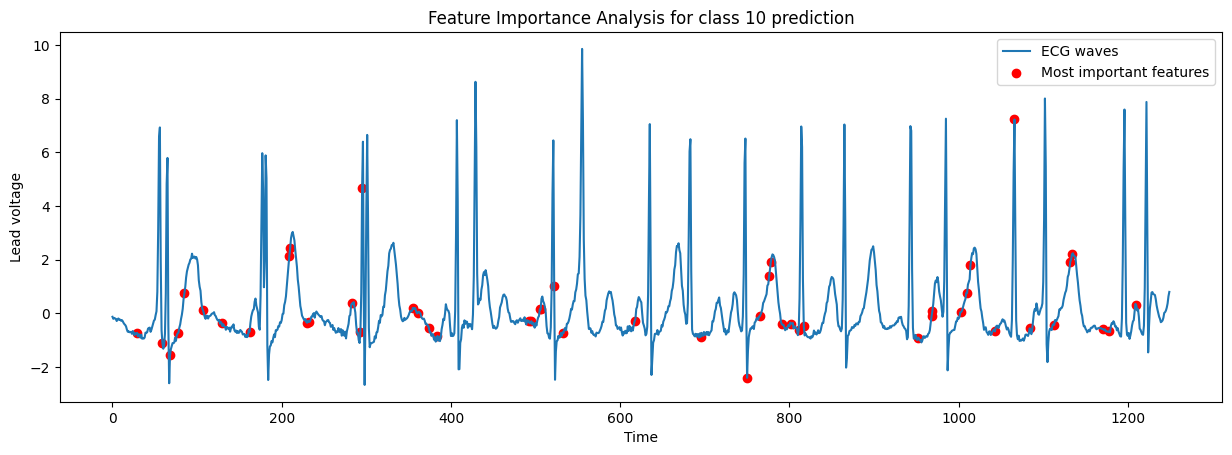


Explain prediction for class 11:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 11 prediction:

Feature 95 - Contribution value: 0.024301326134127534
Feature 778 - Contribution value: 0.022266120990826234
Feature 1150 - Contribution value: 0.021698146439925705
Feature 749 - Contribution value: 0.021339180399977828
Feature 319 - Contribution value: 0.02100395514635689
Feature 479 - Contribution value: 0.020572715508729193
Feature 868 - Contribution value: 0.020559422638827585
Feature 131 - Contribution value: 0.02010174376596602
Feature 57 - Contribution value: 0.020029905545571387
Feature 111 - Contribution value: 0.019664635468911982
Feature 50 - Contribution value: 0.019402733793860615
Feature 850 - Contribution value: 0.01937327049239573
Feature 906 - Contribution value: 0.01929882977173
Feature 724 - Contribution value: 0.019018751481388572
Feature 776 - Contribution value: 0.018737543855257287
Feature 708 - Contribution value: 0.01855247996342587

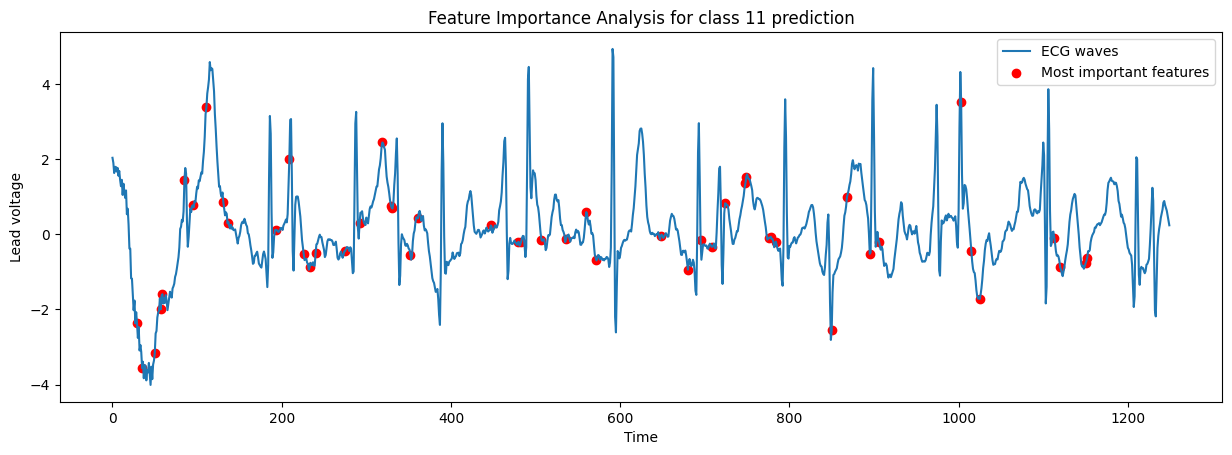


Explain prediction for class 12:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 12 prediction:

Feature 368 - Contribution value: 0.02445657261482876
Feature 28 - Contribution value: 0.023924033969241365
Feature 987 - Contribution value: 0.0221815902642019
Feature 776 - Contribution value: 0.02188127405282901
Feature 1132 - Contribution value: 0.02144699862102203
Feature 561 - Contribution value: 0.02066936844065026
Feature 936 - Contribution value: 0.02047547261298604
Feature 953 - Contribution value: 0.020273805057591316
Feature 581 - Contribution value: 0.0202415080636079
Feature 874 - Contribution value: 0.019967076372230226
Feature 894 - Contribution value: 0.01977655451888742
Feature 1150 - Contribution value: 0.019610392117414766
Feature 1121 - Contribution value: 0.019433705449081223
Feature 292 - Contribution value: 0.018994861481496136
Feature 259 - Contribution value: 0.018807742637877226
Feature 1176 - Contribution value: 0.018735276649991

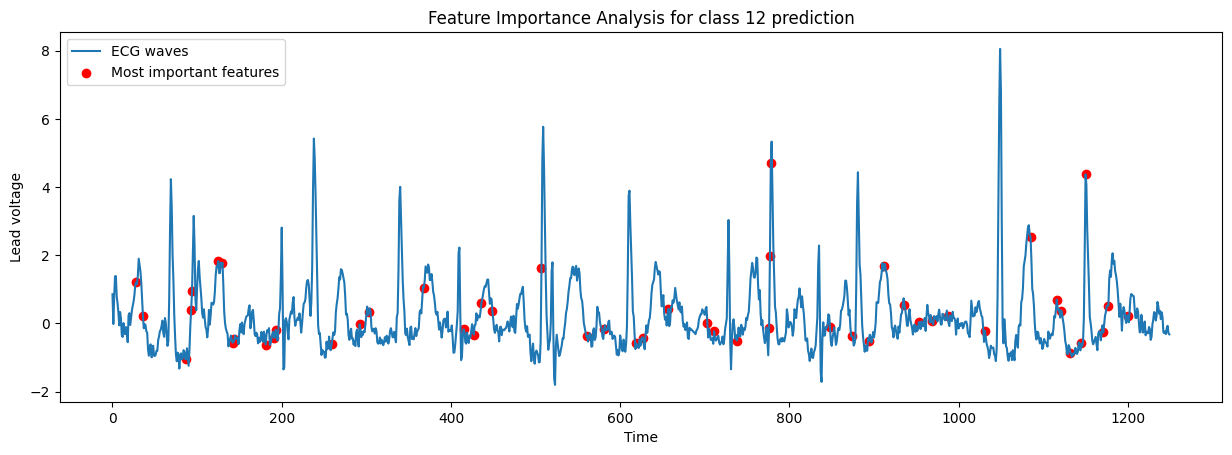


Explain prediction for class 13:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 13 prediction:

Feature 506 - Contribution value: 0.028441250856828026
Feature 985 - Contribution value: 0.026118239672787702
Feature 1042 - Contribution value: 0.024810551271187732
Feature 599 - Contribution value: 0.02453858357975481
Feature 68 - Contribution value: 0.021719868131948632
Feature 778 - Contribution value: 0.02141242551741107
Feature 51 - Contribution value: 0.020765473053866054
Feature 319 - Contribution value: 0.02030232294301692
Feature 426 - Contribution value: 0.020206848908842858
Feature 546 - Contribution value: 0.020029746674297605
Feature 107 - Contribution value: 0.019864093971406118
Feature 353 - Contribution value: 0.019762030134750187
Feature 416 - Contribution value: 0.019391264864187054
Feature 1102 - Contribution value: 0.019358179271232966
Feature 791 - Contribution value: 0.018864058732453632
Feature 580 - Contribution value: 0.01886280489

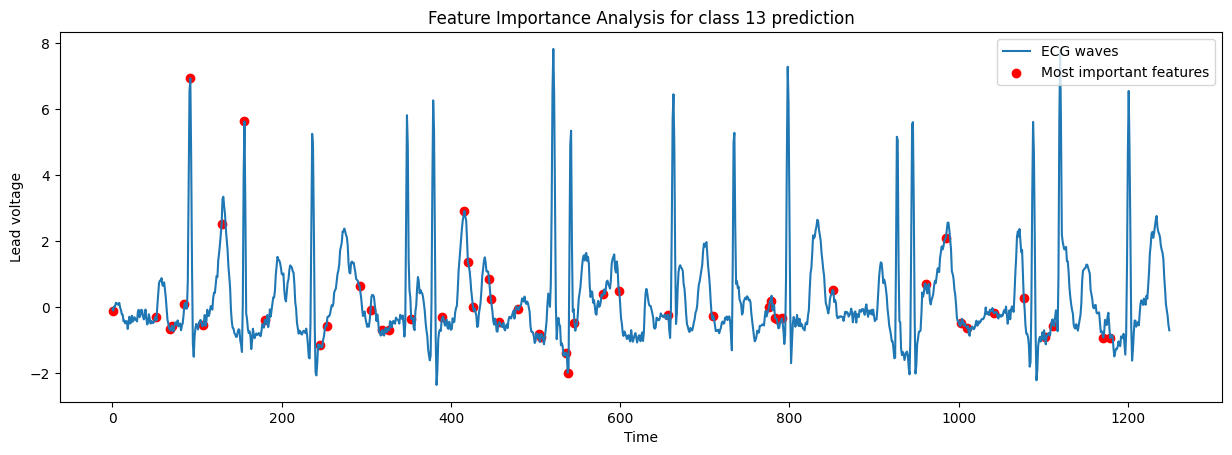


Explain prediction for class 14:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 14 prediction:

Feature 287 - Contribution value: 0.03065793933669496
Feature 350 - Contribution value: 0.02589926402812364
Feature 1014 - Contribution value: 0.024019690072179623
Feature 1113 - Contribution value: 0.02335536282707859
Feature 262 - Contribution value: 0.023021441596016486
Feature 676 - Contribution value: 0.02116917680911607
Feature 1032 - Contribution value: 0.020603883941954875
Feature 129 - Contribution value: 0.02025668054123459
Feature 371 - Contribution value: 0.020221020120724312
Feature 808 - Contribution value: 0.020140176595966664
Feature 427 - Contribution value: 0.019756597724567882
Feature 849 - Contribution value: 0.019646807313777902
Feature 869 - Contribution value: 0.019553565696163636
Feature 1050 - Contribution value: 0.019546654210895964
Feature 395 - Contribution value: 0.018652861434849524
Feature 1073 - Contribution value: 0.01855389

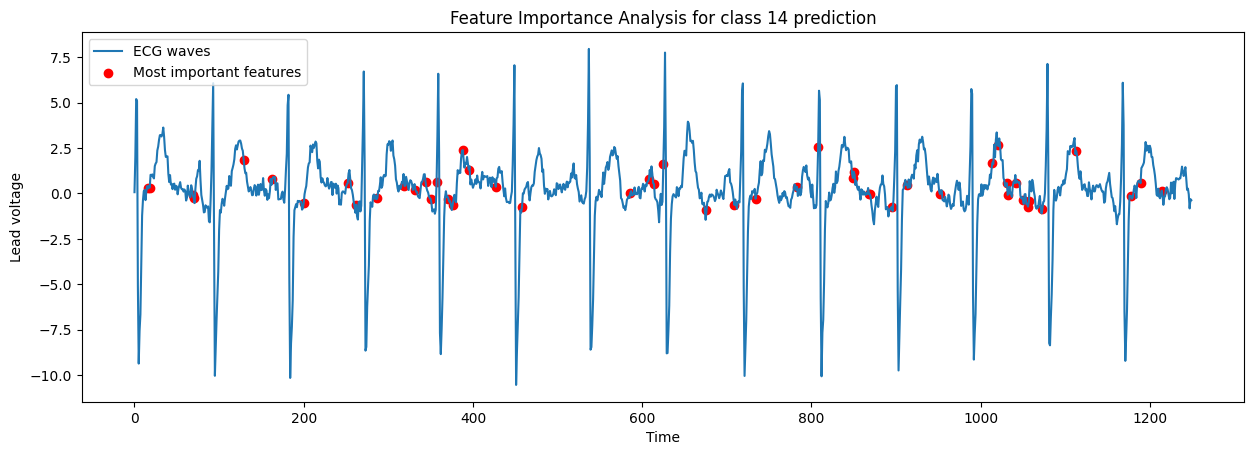


Explain prediction for class 15:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 15 prediction:

Feature 513 - Contribution value: 0.026496527926397836
Feature 1115 - Contribution value: 0.025803665797117206
Feature 700 - Contribution value: 0.02456709930121395
Feature 574 - Contribution value: 0.02166532782494486
Feature 125 - Contribution value: 0.021629469593079195
Feature 100 - Contribution value: 0.02134232048606229
Feature 725 - Contribution value: 0.021162500979064778
Feature 247 - Contribution value: 0.020274029631915953
Feature 403 - Contribution value: 0.019960756694032415
Feature 1224 - Contribution value: 0.01972476749295003
Feature 448 - Contribution value: 0.019353941302056206
Feature 1151 - Contribution value: 0.019115189986379358
Feature 1178 - Contribution value: 0.019030123134507068
Feature 865 - Contribution value: 0.018901343946149146
Feature 113 - Contribution value: 0.018858444557894868
Feature 388 - Contribution value: 0.01842544

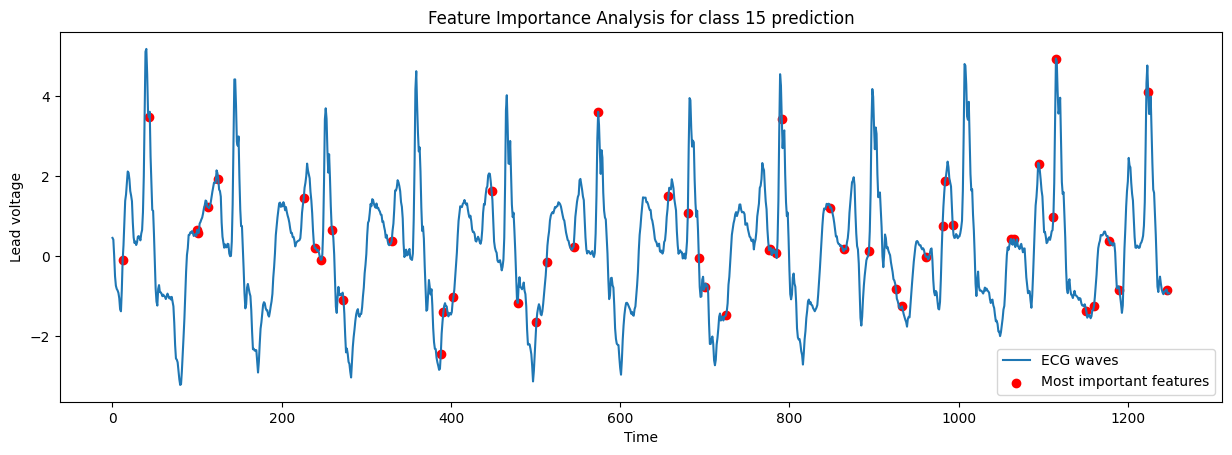


Explain prediction for class 16:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 16 prediction:

Feature 481 - Contribution value: 0.027129614816098872
Feature 1134 - Contribution value: 0.026924202578346317
Feature 779 - Contribution value: 0.022571345668933554
Feature 1003 - Contribution value: 0.022331761883739355
Feature 778 - Contribution value: 0.021760200285145814
Feature 48 - Contribution value: 0.021638240890892012
Feature 708 - Contribution value: 0.021456998073629652
Feature 423 - Contribution value: 0.020978064322116845
Feature 105 - Contribution value: 0.02050122856817009
Feature 538 - Contribution value: 0.01870846700850815
Feature 23 - Contribution value: 0.018693911315498652
Feature 281 - Contribution value: 0.018487839394517588
Feature 837 - Contribution value: 0.01842825836958097
Feature 107 - Contribution value: 0.018277867072402008
Feature 1184 - Contribution value: 0.01811456547666854
Feature 70 - Contribution value: 0.018064495447

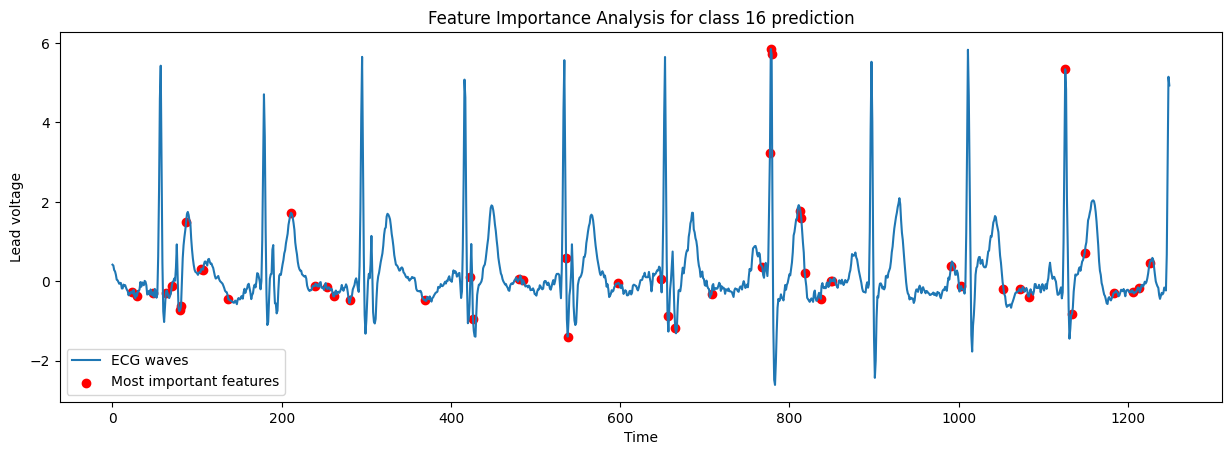


Explain prediction for class 17:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 17 prediction:

Feature 1108 - Contribution value: 0.02472475708058698
Feature 31 - Contribution value: 0.023634730684416946
Feature 776 - Contribution value: 0.02224911947350701
Feature 778 - Contribution value: 0.02198239266366052
Feature 767 - Contribution value: 0.021856277046457567
Feature 725 - Contribution value: 0.021632725843590817
Feature 427 - Contribution value: 0.020008485053220126
Feature 931 - Contribution value: 0.019772549637032354
Feature 1121 - Contribution value: 0.019750951924876657
Feature 568 - Contribution value: 0.019596258159489163
Feature 946 - Contribution value: 0.019369911067363448
Feature 1056 - Contribution value: 0.019103531130688082
Feature 309 - Contribution value: 0.01883727071745847
Feature 287 - Contribution value: 0.0185877554587447
Feature 437 - Contribution value: 0.01804576000039706
Feature 1113 - Contribution value: 0.017953377904

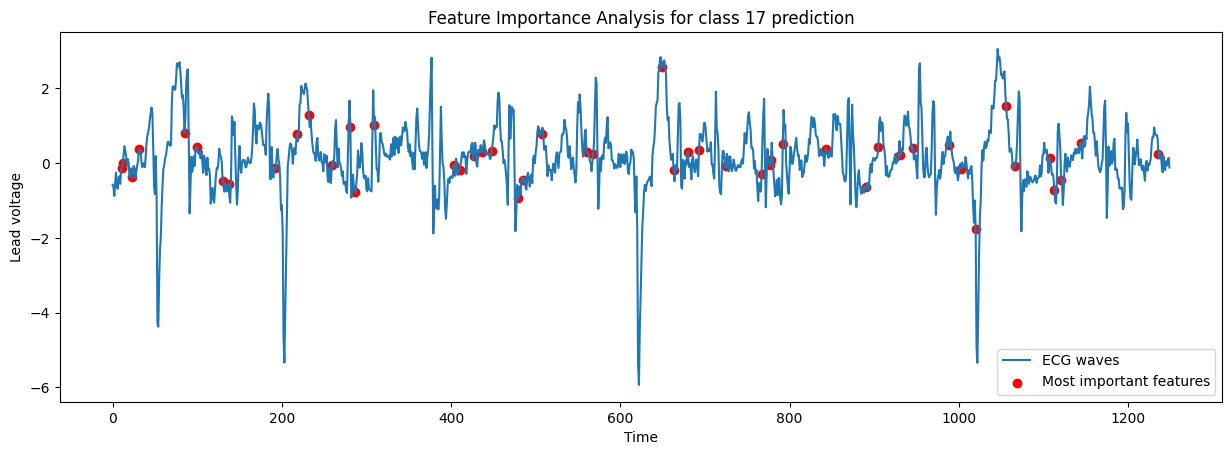


Explain prediction for class 18:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 18 prediction:

Feature 180 - Contribution value: 0.02608982721097117
Feature 482 - Contribution value: 0.023706323859524273
Feature 1009 - Contribution value: 0.022541883092829708
Feature 489 - Contribution value: 0.021644364450876155
Feature 513 - Contribution value: 0.02043032851969896
Feature 483 - Contribution value: 0.0199710433508488
Feature 125 - Contribution value: 0.019865369612386663
Feature 260 - Contribution value: 0.019827773330361835
Feature 69 - Contribution value: 0.019824034479122954
Feature 783 - Contribution value: 0.01959720531152803
Feature 791 - Contribution value: 0.019165206688217494
Feature 61 - Contribution value: 0.01901400604435199
Feature 785 - Contribution value: 0.018552879635566337
Feature 211 - Contribution value: 0.018224877265257546
Feature 905 - Contribution value: 0.01803944434589757
Feature 130 - Contribution value: 0.0178335709522582

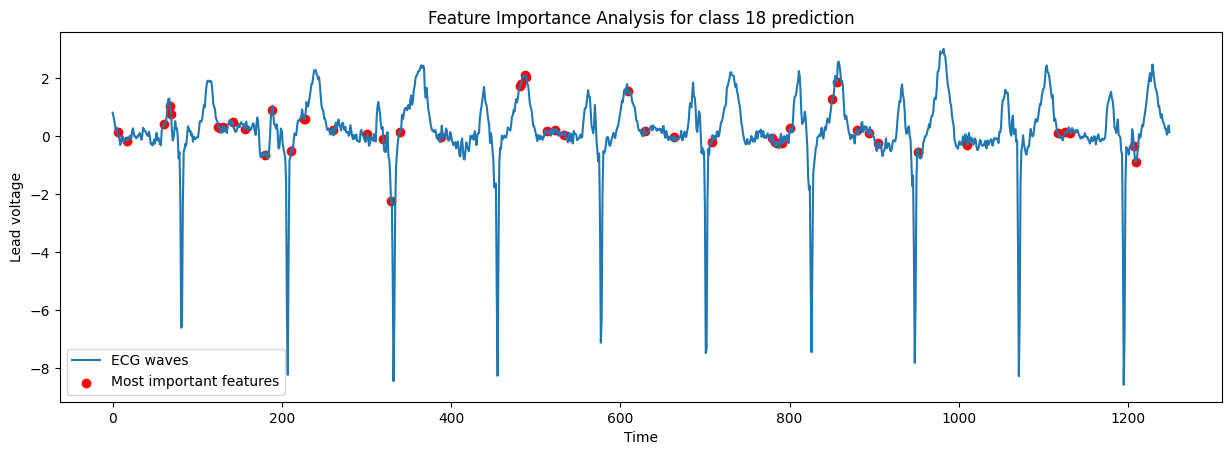


Explain prediction for class 19:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 19 prediction:

Feature 129 - Contribution value: 0.026511155865280238
Feature 426 - Contribution value: 0.025758714642754244
Feature 1208 - Contribution value: 0.025346765020811207
Feature 48 - Contribution value: 0.02518564203601495
Feature 779 - Contribution value: 0.022862210326243887
Feature 253 - Contribution value: 0.02073827267718946
Feature 1135 - Contribution value: 0.020623879161102344
Feature 15 - Contribution value: 0.020513702395002484
Feature 1007 - Contribution value: 0.02027746063125081
Feature 451 - Contribution value: 0.02011387966667414
Feature 319 - Contribution value: 0.019811933488096033
Feature 113 - Contribution value: 0.019665823503153275
Feature 144 - Contribution value: 0.01966523532744554
Feature 777 - Contribution value: 0.018512980806989317
Feature 1204 - Contribution value: 0.018217554335700388
Feature 1115 - Contribution value: 0.0181949187

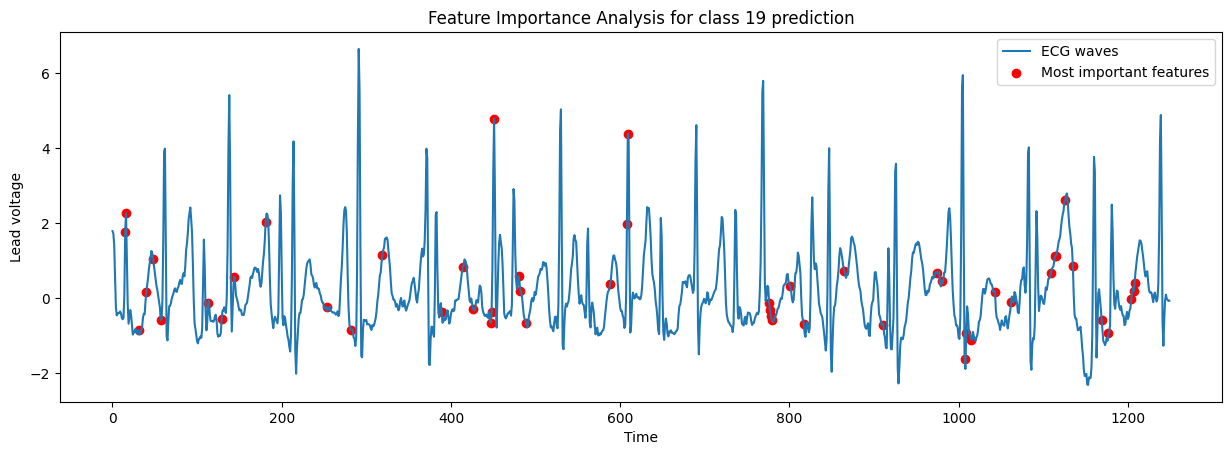


Explain prediction for class 20:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 20 prediction:

Feature 53 - Contribution value: 0.026933836831796665
Feature 801 - Contribution value: 0.0225476033759527
Feature 16 - Contribution value: 0.022387781505615417
Feature 388 - Contribution value: 0.022164178516883303
Feature 482 - Contribution value: 0.021907079247485528
Feature 39 - Contribution value: 0.02110708780665094
Feature 1151 - Contribution value: 0.020989089804125383
Feature 1066 - Contribution value: 0.0202177316942351
Feature 904 - Contribution value: 0.019337682955176974
Feature 944 - Contribution value: 0.01899740168260085
Feature 791 - Contribution value: 0.01888535449273365
Feature 105 - Contribution value: 0.018665084012806227
Feature 468 - Contribution value: 0.018549935367189366
Feature 996 - Contribution value: 0.018339981178186342
Feature 1115 - Contribution value: 0.01796271659480058
Feature 135 - Contribution value: 0.0179223515303363

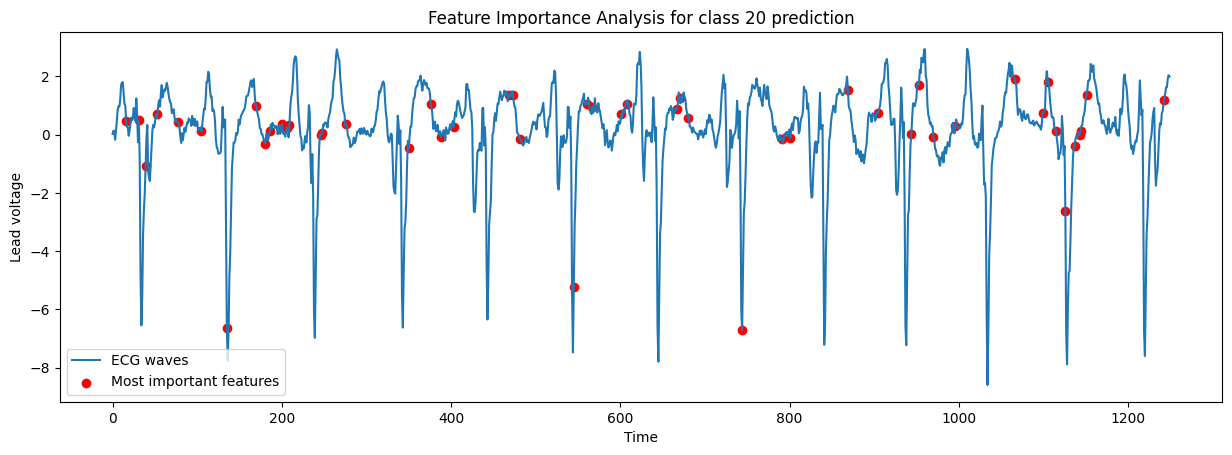


Explain prediction for class 21:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 21 prediction:

Feature 79 - Contribution value: 0.024695969682176137
Feature 33 - Contribution value: 0.024309866052527915
Feature 162 - Contribution value: 0.024183668872888035
Feature 588 - Contribution value: 0.023038118874045617
Feature 355 - Contribution value: 0.022818299136771702
Feature 791 - Contribution value: 0.02204641704751355
Feature 479 - Contribution value: 0.02195416815974164
Feature 680 - Contribution value: 0.021855219005098937
Feature 330 - Contribution value: 0.021789340368929547
Feature 447 - Contribution value: 0.021405689755004266
Feature 125 - Contribution value: 0.021248823734763517
Feature 29 - Contribution value: 0.021029786714376636
Feature 599 - Contribution value: 0.020879166150756502
Feature 416 - Contribution value: 0.0205653591419954
Feature 143 - Contribution value: 0.0204135653035151
Feature 671 - Contribution value: 0.02012732905390531

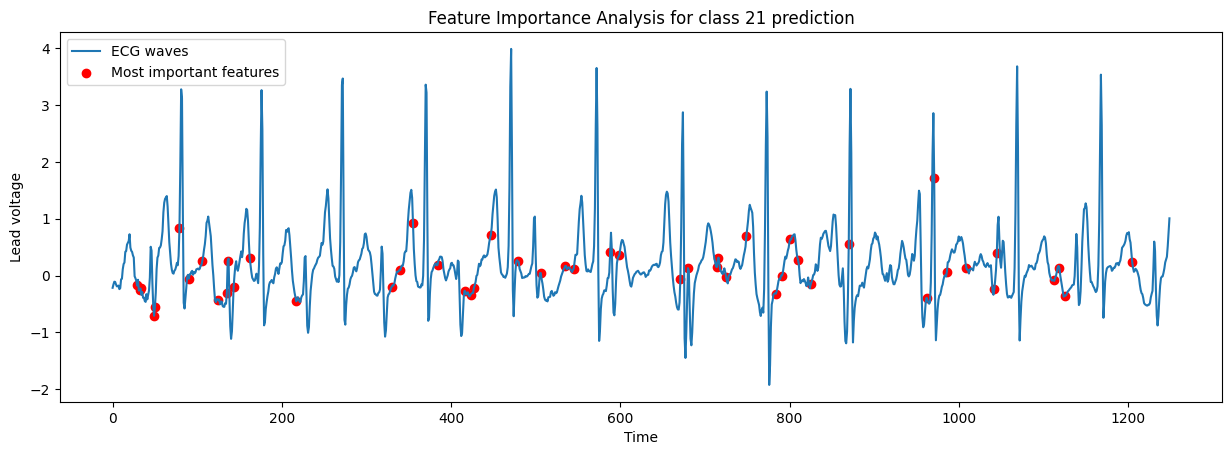


Explain prediction for class 22:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 22 prediction:

Feature 802 - Contribution value: 0.03118905417771901
Feature 87 - Contribution value: 0.02925989766401916
Feature 127 - Contribution value: 0.02614125469681945
Feature 784 - Contribution value: 0.023743434584682692
Feature 16 - Contribution value: 0.023044547081036794
Feature 480 - Contribution value: 0.022967941463878545
Feature 465 - Contribution value: 0.02236908634095962
Feature 240 - Contribution value: 0.01992082817233331
Feature 939 - Contribution value: 0.018875980980412713
Feature 85 - Contribution value: 0.01884383026794846
Feature 492 - Contribution value: 0.018693636106100735
Feature 952 - Contribution value: 0.01843077201581636
Feature 691 - Contribution value: 0.018102432428842054
Feature 31 - Contribution value: 0.018087292312978825
Feature 969 - Contribution value: 0.01793173938181043
Feature 330 - Contribution value: 0.017733285952325217
F

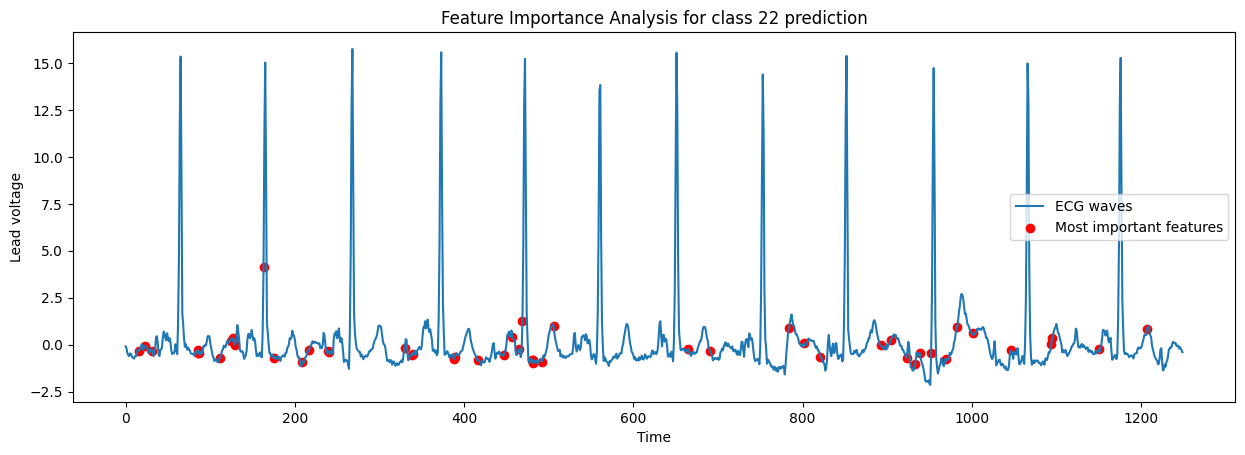


Explain prediction for class 23:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 23 prediction:

Feature 416 - Contribution value: 0.027953408178285587
Feature 1211 - Contribution value: 0.02510336890350875
Feature 785 - Contribution value: 0.02229531128852459
Feature 1126 - Contribution value: 0.021899930748581622
Feature 198 - Contribution value: 0.02182775673446119
Feature 113 - Contribution value: 0.021718548044534124
Feature 240 - Contribution value: 0.020651119432969295
Feature 492 - Contribution value: 0.020453621438404474
Feature 500 - Contribution value: 0.02017183194520613
Feature 552 - Contribution value: 0.019850828996146815
Feature 1042 - Contribution value: 0.018870083636911537
Feature 869 - Contribution value: 0.01869898795394189
Feature 680 - Contribution value: 0.018612463479347276
Feature 255 - Contribution value: 0.018571419643840955
Feature 209 - Contribution value: 0.018530871105294906
Feature 1116 - Contribution value: 0.017704754

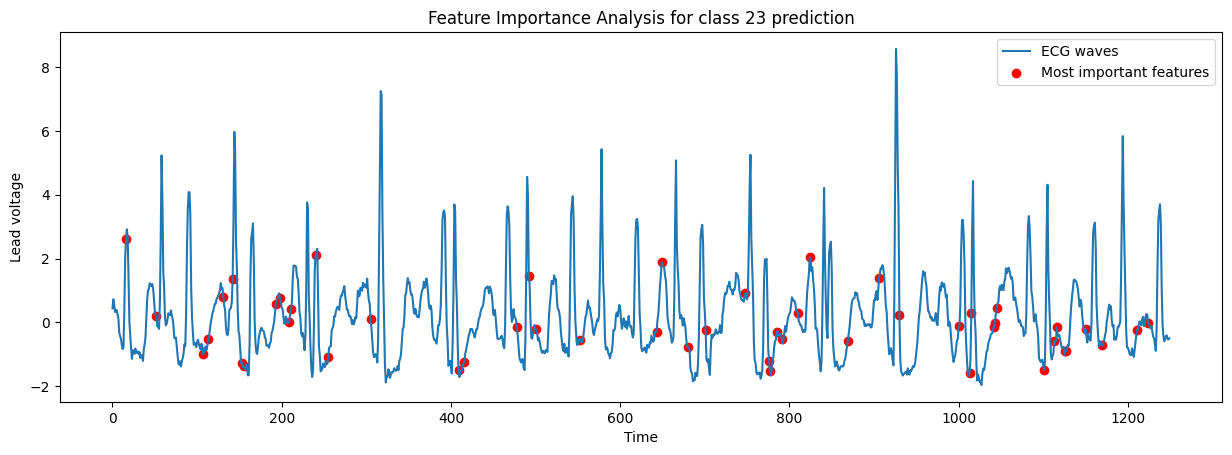


Explain prediction for class 24:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 24 prediction:

Feature 482 - Contribution value: 0.032340688998748486
Feature 727 - Contribution value: 0.023646207214121227
Feature 51 - Contribution value: 0.023201250842281335
Feature 332 - Contribution value: 0.021283411647401267
Feature 170 - Contribution value: 0.020993434140125385
Feature 137 - Contribution value: 0.020632501259603035
Feature 29 - Contribution value: 0.020485313104584728
Feature 1200 - Contribution value: 0.020408064991731138
Feature 13 - Contribution value: 0.02032122696559887
Feature 492 - Contribution value: 0.020291963003449143
Feature 1113 - Contribution value: 0.020267922820108298
Feature 70 - Contribution value: 0.019869343756074822
Feature 47 - Contribution value: 0.01863493087042506
Feature 281 - Contribution value: 0.01830424829933035
Feature 493 - Contribution value: 0.018158826367147163
Feature 1072 - Contribution value: 0.0181147476311

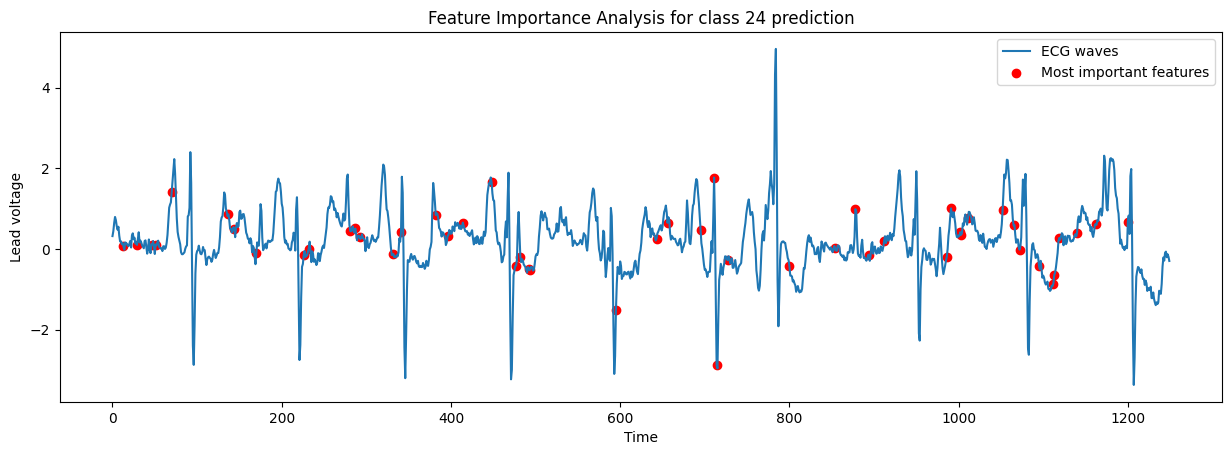


Explain prediction for class 25:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 25 prediction:

Feature 153 - Contribution value: 0.02827108426047059
Feature 1098 - Contribution value: 0.026750352335414673
Feature 391 - Contribution value: 0.026007830308828892
Feature 129 - Contribution value: 0.02374226652929695
Feature 783 - Contribution value: 0.023425684524586748
Feature 1041 - Contribution value: 0.022987752529142404
Feature 23 - Contribution value: 0.021327785103805157
Feature 350 - Contribution value: 0.021120051638826094
Feature 330 - Contribution value: 0.020864127014907377
Feature 1151 - Contribution value: 0.02012177908827388
Feature 724 - Contribution value: 0.019568464347631556
Feature 1150 - Contribution value: 0.019529891273243997
Feature 57 - Contribution value: 0.019413520512292955
Feature 293 - Contribution value: 0.019156412992531548
Feature 390 - Contribution value: 0.018948906725180275
Feature 1013 - Contribution value: 0.01826389

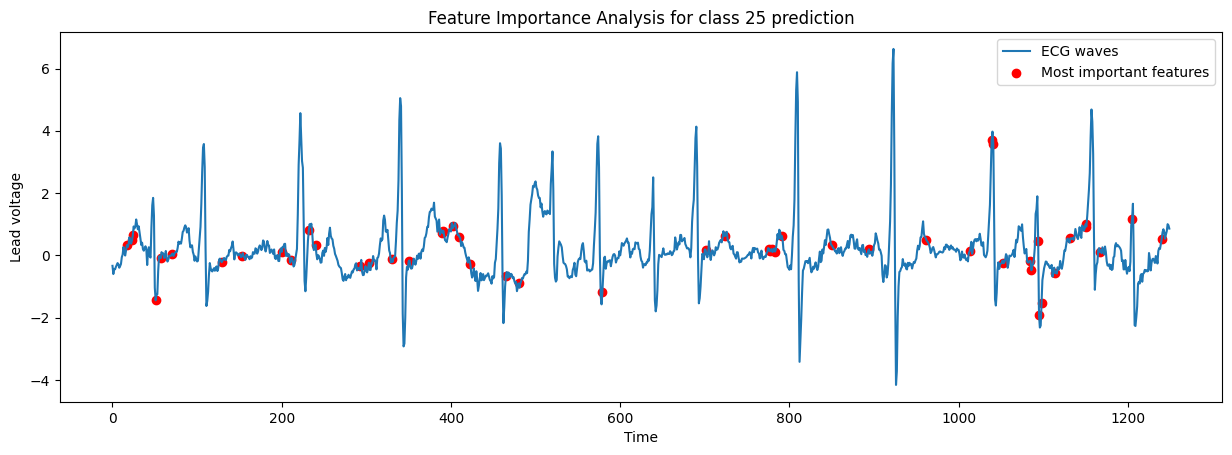


Explain prediction for class 26:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 26 prediction:

Feature 482 - Contribution value: 0.029380653061861273
Feature 500 - Contribution value: 0.02703827312528173
Feature 309 - Contribution value: 0.0251797594405208
Feature 1113 - Contribution value: 0.024380824175343693
Feature 303 - Contribution value: 0.01998560788309322
Feature 211 - Contribution value: 0.01979759307602639
Feature 826 - Contribution value: 0.019691003935827445
Feature 1112 - Contribution value: 0.019444158655498863
Feature 1073 - Contribution value: 0.018101154656038416
Feature 846 - Contribution value: 0.01805125823689636
Feature 885 - Contribution value: 0.017781547821623427
Feature 824 - Contribution value: 0.017775565763544925
Feature 227 - Contribution value: 0.017761528374876132
Feature 930 - Contribution value: 0.017740749864815848
Feature 481 - Contribution value: 0.01727226554961856
Feature 457 - Contribution value: 0.017040518436

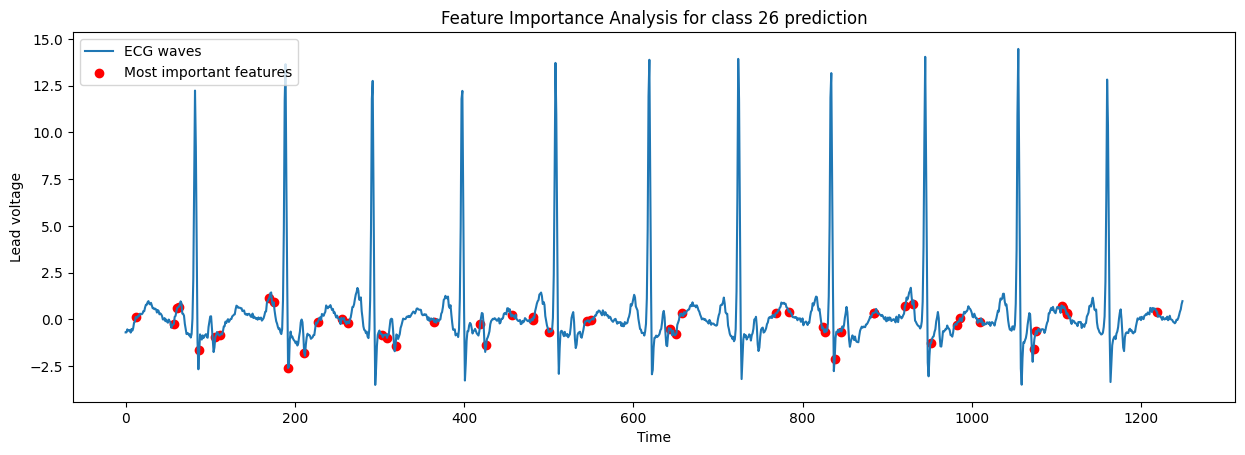


Explain prediction for class 27:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 27 prediction:

Feature 1184 - Contribution value: 0.025165224291048297
Feature 69 - Contribution value: 0.02205995866441591
Feature 643 - Contribution value: 0.021910277608309856
Feature 36 - Contribution value: 0.020562598011309725
Feature 694 - Contribution value: 0.020160791747852395
Feature 962 - Contribution value: 0.020042366398666158
Feature 423 - Contribution value: 0.019666165009626087
Feature 287 - Contribution value: 0.019603397388548566
Feature 124 - Contribution value: 0.01924479136343482
Feature 17 - Contribution value: 0.019221796764263714
Feature 403 - Contribution value: 0.018936255944715135
Feature 558 - Contribution value: 0.01846341826194701
Feature 246 - Contribution value: 0.018375317494558757
Feature 871 - Contribution value: 0.017966145680686347
Feature 151 - Contribution value: 0.017908211223187493
Feature 24 - Contribution value: 0.01784208034136

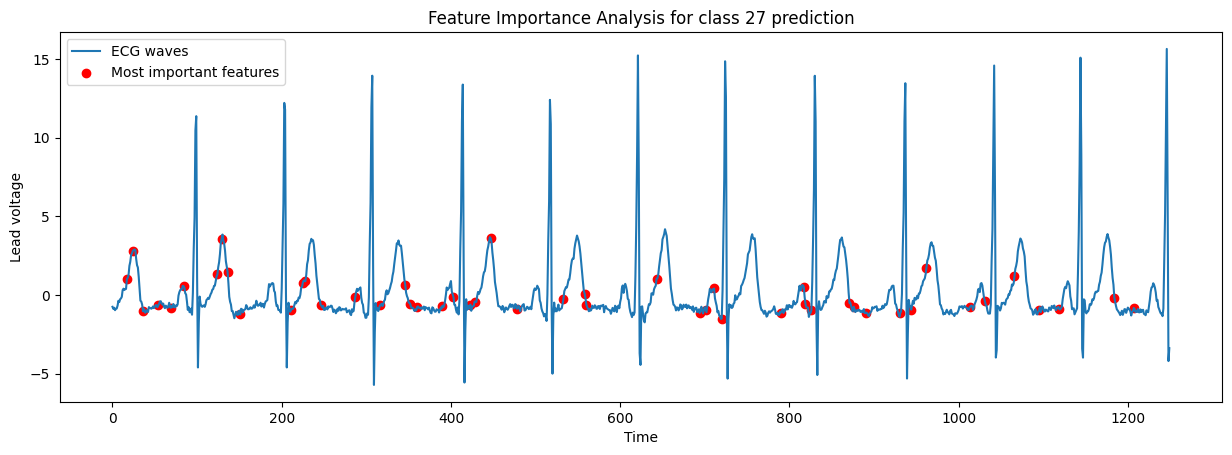


Explain prediction for class 28:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 28 prediction:

Feature 239 - Contribution value: 0.03052263773080891
Feature 725 - Contribution value: 0.027157241868594018
Feature 506 - Contribution value: 0.02272620930852202
Feature 397 - Contribution value: 0.022258445934935752
Feature 930 - Contribution value: 0.021025269515944307
Feature 28 - Contribution value: 0.02074225530784565
Feature 330 - Contribution value: 0.02065343189235983
Feature 907 - Contribution value: 0.020411880023903248
Feature 952 - Contribution value: 0.020364739963274543
Feature 57 - Contribution value: 0.01995759413880857
Feature 58 - Contribution value: 0.019823401293073358
Feature 233 - Contribution value: 0.019335983659410957
Feature 931 - Contribution value: 0.01913588379341201
Feature 181 - Contribution value: 0.018546486773953
Feature 331 - Contribution value: 0.018371350889830478
Feature 360 - Contribution value: 0.018115281597842897
F

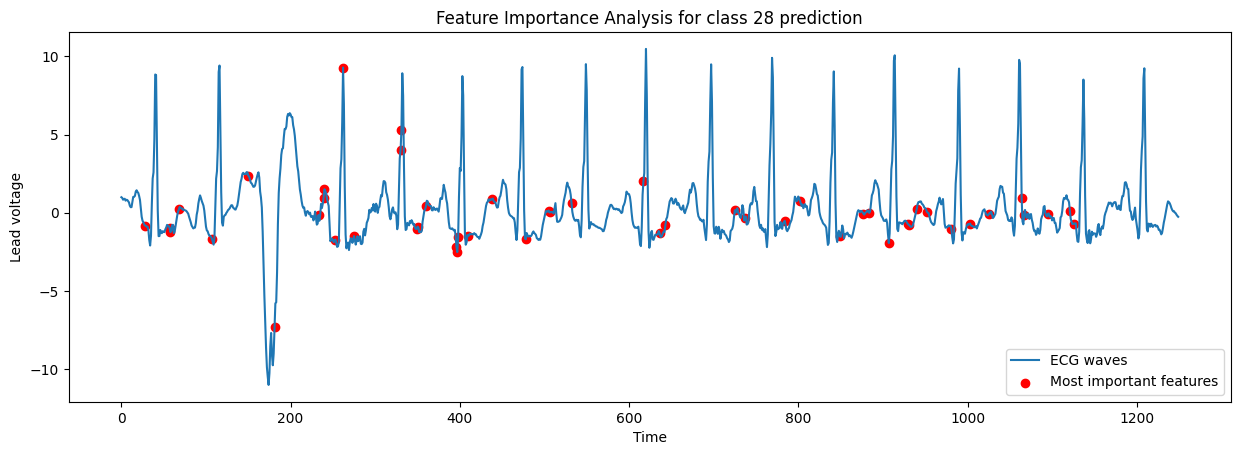


Explain prediction for class 29:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 29 prediction:

Feature 239 - Contribution value: 0.023085716279369534
Feature 129 - Contribution value: 0.021160765697170875
Feature 711 - Contribution value: 0.02100959458375946
Feature 642 - Contribution value: 0.0202634804859801
Feature 535 - Contribution value: 0.020106937931495997
Feature 426 - Contribution value: 0.020063173149096506
Feature 1207 - Contribution value: 0.019885634716589908
Feature 818 - Contribution value: 0.018999350105044714
Feature 402 - Contribution value: 0.018477903802219482
Feature 649 - Contribution value: 0.018454159678950716
Feature 777 - Contribution value: 0.01837901053408172
Feature 143 - Contribution value: 0.018289846429067395
Feature 1217 - Contribution value: 0.01820867566292201
Feature 330 - Contribution value: 0.01769170437520855
Feature 906 - Contribution value: 0.017630128249277403
Feature 791 - Contribution value: 0.017480015781

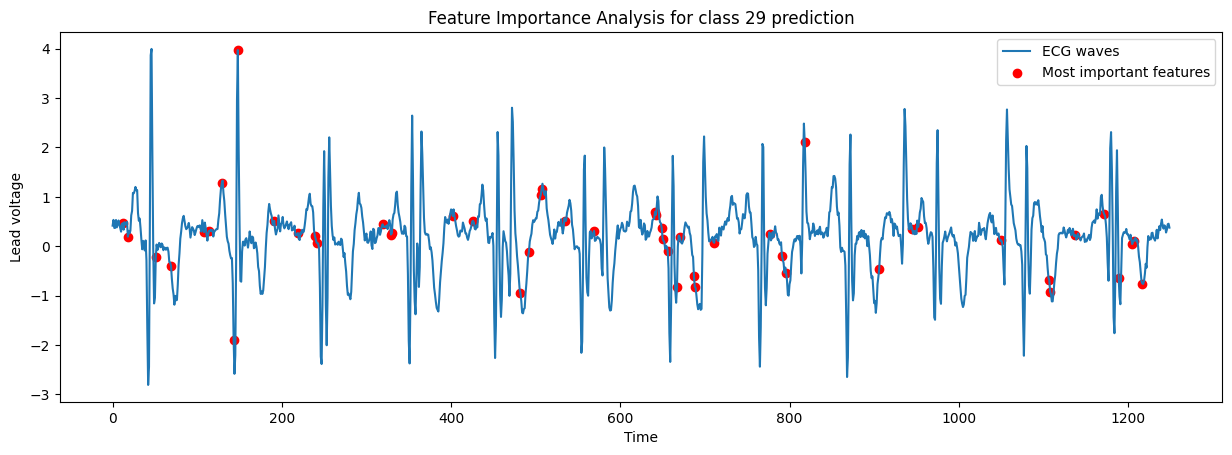


Explain prediction for class 30:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 30 prediction:

Feature 604 - Contribution value: 0.023792027729901813
Feature 885 - Contribution value: 0.023593376700513716
Feature 192 - Contribution value: 0.022279062423281565
Feature 219 - Contribution value: 0.021589773771043045
Feature 479 - Contribution value: 0.021450118432035162
Feature 1119 - Contribution value: 0.02080572576711853
Feature 1151 - Contribution value: 0.020539969640279532
Feature 468 - Contribution value: 0.019752558698789675
Feature 48 - Contribution value: 0.019638004473292305
Feature 776 - Contribution value: 0.019263893864231357
Feature 130 - Contribution value: 0.019107938344393685
Feature 726 - Contribution value: 0.01876142000578999
Feature 826 - Contribution value: 0.01874869104927985
Feature 884 - Contribution value: 0.01842248628306359
Feature 1205 - Contribution value: 0.01839864767940782
Feature 1101 - Contribution value: 0.0181399718

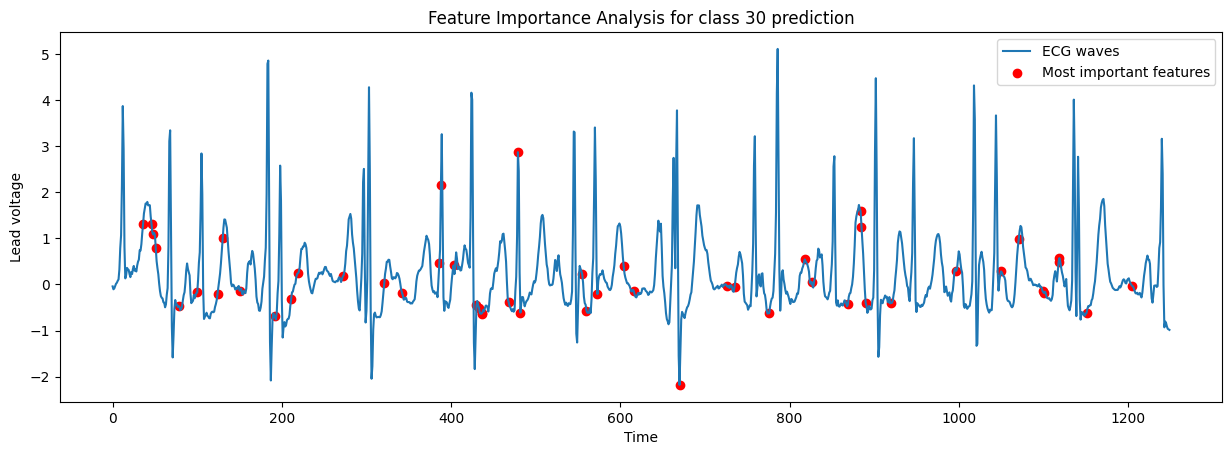


Explain prediction for class 31:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Top 30 feature contributions to class 31 prediction:

Feature 137 - Contribution value: 0.028768828214186203
Feature 175 - Contribution value: 0.0260999593586785
Feature 1115 - Contribution value: 0.025711233680164165
Feature 181 - Contribution value: 0.024988879142587322
Feature 46 - Contribution value: 0.023382093949495416
Feature 871 - Contribution value: 0.02287667261967385
Feature 69 - Contribution value: 0.022222087016120627
Feature 675 - Contribution value: 0.022093275675539464
Feature 667 - Contribution value: 0.0220806037585986
Feature 776 - Contribution value: 0.021919217644051102
Feature 1078 - Contribution value: 0.021818832916211547
Feature 482 - Contribution value: 0.02131569904377836
Feature 492 - Contribution value: 0.021294314521578293
Feature 447 - Contribution value: 0.020714657985043225
Feature 270 - Contribution value: 0.02046554925726846
Feature 1150 - Contribution value: 0.02043451267142

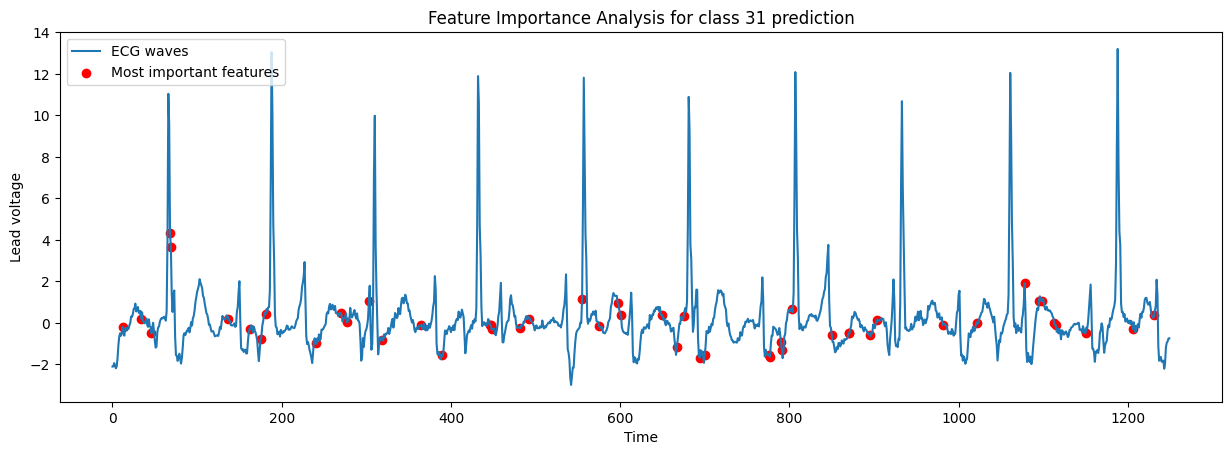

In [12]:
# Load model config.
reloaded_model = load_model("../modelconfig/v1_model.h5")

selected_samples = []
for classes_idx in range(32):
   found_idxs = [i for i, x in enumerate(y_train) if x == classes_idx][:1000]
   selected_samples.extend(found_idxs)
X_background = X_train[selected_samples]
y_background = y_train[selected_samples]
feature_names = [str(x) for x in range(1250)]
class_names = [str(x) for x in range(32)]

# Select one sample of each class to explain.
x_test_dict = dict()
for i, l in enumerate(y_test):
   if len(x_test_dict) == 32:
      break
   if l not in x_test_dict.keys():
      x_test_dict[l] = X_test[i]

# Explain model predictions.
explainer = lime.lime_tabular.RecurrentTabularExplainer(X_background, training_labels = y_background,
                                                        feature_names = feature_names, discretize_continuous = False,
                                                        feature_selection = "auto",
                                                        class_names = class_names)
list_of_steps = np.arange(start = 0, stop = 1250)
for classes_idx in range(32):
    print("\nExplain prediction for class {}:\n".format(classes_idx))
    exp = explainer.explain_instance(np.expand_dims(x_test_dict[classes_idx], axis = 0),
                                    reloaded_model.predict, num_features = 1250)
    sorted_data = sorted(exp.as_list(), key = lambda x : x[1], reverse = True)
    top_125 = sorted_data[:50]
    print("\nTop 30 feature contributions to class {} prediction:\n".format(classes_idx))
    top_125_features = []
    for tup_elem in top_125:
        feature_num = str(tup_elem[0]).replace("0_t-", "")
        print("Feature {} - Contribution value: {}".format(feature_num, tup_elem[1]))
        top_125_features.append(int(feature_num))
    print("\n")
    plt.figure().set_figwidth(15)
    plt.plot(list_of_steps, x_test_dict[classes_idx], label = "ECG waves")
    plt.scatter(list_of_steps[top_125_features], x_test_dict[classes_idx][top_125_features],
                color = "r", label = "Most important features")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Lead voltage')
    plt.title('Feature Importance Analysis for class {} prediction'.format(classes_idx))
    plt.show()


#### Plot confusion matrix of model predictions.

c:\DeveloperTools\python\3.11.0\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\DeveloperTools\python\3.11.0\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(




1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


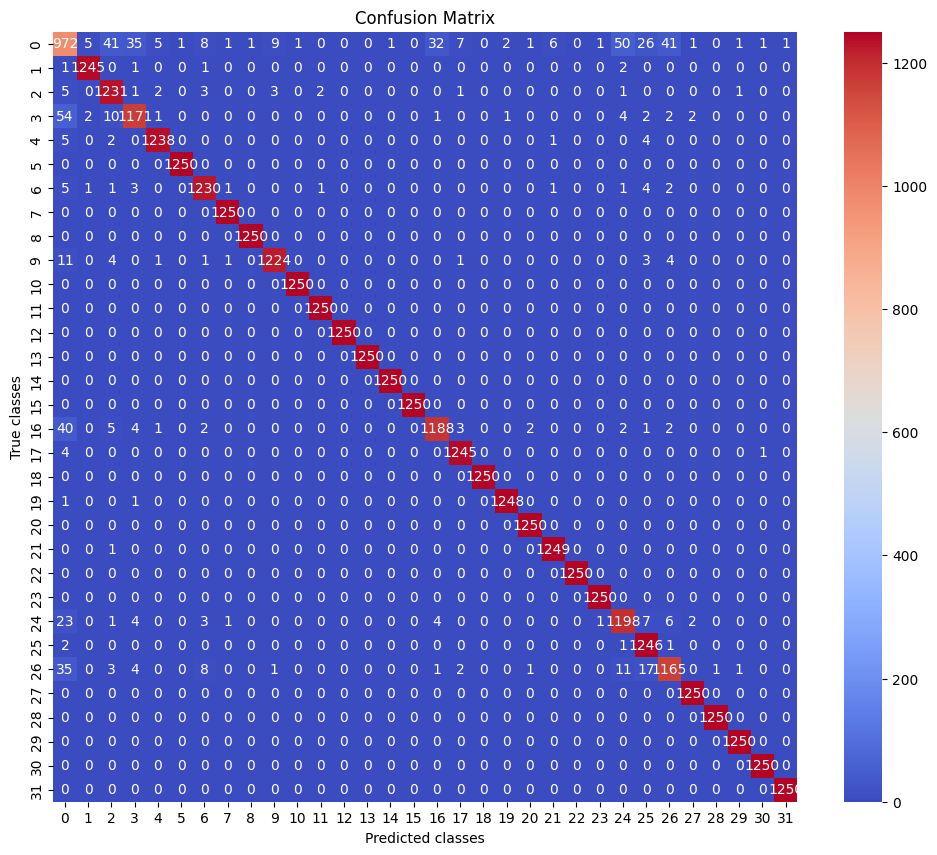

In [42]:

# Load model config.
reloaded_model = load_model("../modelconfig/v1_model.h5")
print("\n")

# Calculate confusion matrix.
y_pred_prob = reloaded_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
cm = confusion_matrix(y_test, y_pred)

# Plot a heatmap.
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "coolwarm")
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()
